In [1]:
from pymutspec import draw
import pandas as pd
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import numpy as np
from scipy.stats import ttest_ind, wilcoxon, mannwhitneyu, f_oneway, zscore, spearmanr
from scipy.spatial.distance import pdist, cdist
import re

# Swap that to True if you want to invert nucls
INVERT = True
#Change to true to filter mutspecs by num of total muts and num of mut types
FILTER = True
PATH_TO_12MUTSPEC = '/home/gabs/Documents/lab/TermitesAndCockroaches/mtdna-mutspec-insecta/data/NemuPipeline/AllInsects/midori_all_insects_mutspec/ms12syn_internal_iqtree.tsv'
PATH_TO_192MUTSPEC = '/home/gabs/Documents/lab/TermitesAndCockroaches/mtdna-mutspec-insecta/data/NemuPipeline/AllInsects/midori_all_insects_mutspec/ms192syn_internal_iqtree.tsv'
PATH_TO_METADATA = '/home/gabs/Documents/lab/TermitesAndCockroaches/mtdna-mutspec-insecta/data/NemuPipeline/AllInsects/midori_all_insects_mutspec/msMetaData.tsv'
PATH_TO_CODONTABLE = '/mnt/data/Documents/lab/TermitesAndCockroaches/mtdna-mutspec-insecta/data/DescriptiveStat/codontable_midori_Blattodea.csv'
PATH_TO_STRAND_CHECK = '/mnt/data/Documents/lab/TermitesAndCockroaches/mtdna-mutspec-insecta/data/DescriptiveStat/insectsGB_with_diff_strand_loc.tsv'

#df to check whether species has different to Drosophila Melanogaster gene position on strands (+ or -)
'''
Actually I need to see whether species are in a list of species we are sure have similar to Drosophila gene position,
here we check them against a list of species that have different gene position because I didn't want to cut number of species to the level of NCBI availability
'''
strand_check = pd.read_csv(PATH_TO_STRAND_CHECK, sep='\t', index_col=0)
def format_sp(sp):
    return re.sub('\s','_',sp)
strand_check['species'] = strand_check['species'].apply(format_sp)

In [2]:
mutspec12 = pd.read_csv(PATH_TO_12MUTSPEC, sep='\t')
mutspec192 = pd.read_csv(PATH_TO_192MUTSPEC, sep='\t')

In [3]:
def inverter(mutspec12):
    # inverts nucls for ms12, needs to be run only once. DEW IT :3
    # TODO - make it like inverter192 or not, idc
    a_spec = pd.concat([mutspec12[mutspec12['Mut'] == 'A>G'], mutspec12[mutspec12['Mut'] == 'A>C'], mutspec12[mutspec12['Mut'] == 'A>T']])
    t_spec = pd.concat([mutspec12[mutspec12['Mut'] == 'T>G'], mutspec12[mutspec12['Mut'] == 'T>C'], mutspec12[mutspec12['Mut'] == 'T>A']])
    g_spec = pd.concat([mutspec12[mutspec12['Mut'] == 'G>T'], mutspec12[mutspec12['Mut'] == 'G>C'], mutspec12[mutspec12['Mut'] == 'G>A']])
    c_spec = pd.concat([mutspec12[mutspec12['Mut'] == 'C>T'], mutspec12[mutspec12['Mut'] == 'C>G'], mutspec12[mutspec12['Mut'] == 'C>A']])

    a_spec.loc[a_spec['Mut'] == 'A>G', 'Mut'] = 'T>C'
    a_spec.loc[a_spec['Mut'] == 'A>C', 'Mut'] = 'T>G'
    a_spec.loc[a_spec['Mut'] == 'A>T', 'Mut'] = 'T>A'

    t_spec.loc[t_spec['Mut'] == 'T>G', 'Mut'] = 'A>C'
    t_spec.loc[t_spec['Mut'] == 'T>C', 'Mut'] = 'A>G'
    t_spec.loc[t_spec['Mut'] == 'T>A', 'Mut'] = 'A>T'

    g_spec.loc[g_spec['Mut'] == 'G>T', 'Mut'] = 'C>A'
    g_spec.loc[g_spec['Mut'] == 'G>C', 'Mut'] = 'C>G'
    g_spec.loc[g_spec['Mut'] == 'G>A', 'Mut'] = 'C>T'

    c_spec.loc[c_spec['Mut'] == 'C>T', 'Mut'] = 'G>A'
    c_spec.loc[c_spec['Mut'] == 'C>G', 'Mut'] = 'G>C'
    c_spec.loc[c_spec['Mut'] == 'C>A', 'Mut'] = 'G>T'

    mutspec12 = pd.concat([a_spec, t_spec, g_spec, c_spec]).sort_values(by=['Species', 'Mut'])
    return mutspec12

def inverter192(mutspec):
    # inverts nucls for ms192, needs to be run only once
    complement = {'A': 'T', 'T': 'A', 'C': 'G', 'G': 'C'}

    left = mutspec[0]  
    middle = mutspec[1:-1]  
    right = mutspec[-1] 
    
    middle_l, middle_r = middle[1], middle[3]
    
    comp_left = complement[left]
    comp_middle_l = complement[middle_l]
    comp_middle_r = complement[middle_r]
    comp_right = complement[right]
    
    return f"{comp_left}[{comp_middle_l}>{comp_middle_r}]{comp_right}"

if INVERT == True:
    mutspec12 = inverter(mutspec12)
    mutspec192['Mut'] = mutspec192['Mut'].apply(inverter192)

In [4]:
### required when cocks_phylo_stats.r needs NEW FILTERED MUTSPEC
mutspec12 = mutspec12.sort_values(['Species', 'Mut'])
meta_df = pd.read_csv(PATH_TO_METADATA, sep='\t').sort_values(by='Species')


def chop(l, chunk_size):
    for i in range(0, len(l), chunk_size):
        yield l[i:i + chunk_size]

def filter(mutspec12, meta_df, at_least_n_muts=15, at_least_n_mut_types=4, ms_type=12, filter_mut_types=True):
    #removing species with less than 15 total mutations - might need to bump up for all insects (do not do it for termites)
    mut_ammount_df = mutspec12.groupby(mutspec12['Species']).aggregate({'ObsNum' : 'sum'}).reset_index()
    less_than_15_total_muts = mut_ammount_df.drop(mut_ammount_df[mut_ammount_df['ObsNum'] > at_least_n_muts].index)['Species'].to_list()
    for sp in less_than_15_total_muts:
        mutspec12 = mutspec12.drop(mutspec12[mutspec12['Species'] == sp].index)
        meta_df = meta_df.drop(meta_df[meta_df['Species'] == sp].index)

    if filter_mut_types == False:
        return mutspec12, meta_df
    
    #removing species with less than 4 mutation types - might need to bump up for all insects (do not do it for termites)
    species = mutspec12['Species'].drop_duplicates().to_list()
    obsnum_values = mutspec12['ObsNum'].to_list()
    chopped_obsnum =  list(chop(obsnum_values, ms_type))
    
    species_and_obsnum = {}
    for i in range(len(species)):
        species_and_obsnum[species[i]] = chopped_obsnum[i]
    
    less_than_4_mut_types = []
    for sp, obsnum_list in species_and_obsnum.items():
        if obsnum_list.count(0) > 12 - at_least_n_mut_types: # 8 for less than 4 mut types, 4 is less than 8 mut types, 2 is less than 10 mut types, 0 for less than 12 mut type, i.e. all mut types are present
            less_than_4_mut_types.append(sp)
    
    for sp in less_than_4_mut_types:
        mutspec12 = mutspec12.drop(mutspec12[mutspec12['Species'] == sp].index)
        meta_df = meta_df.drop(meta_df[meta_df['Species'] == sp].index)

    return mutspec12, meta_df

if FILTER == True:
    mutspec12, meta_df = filter(mutspec12, meta_df)
    
#half-assed way of converting the table into what I need
mutspec_vals = mutspec12['MutSpec'].to_list()
muts = mutspec12['Mut'].to_list()[0:12]
species = mutspec12['Species'].drop_duplicates().to_list() #need to reset after removing species

chopped_values = list(chop(mutspec_vals, 12))
df_prep = {}
for i in range(len(species)):
    df_prep[species[i]] = chopped_values[i]
df = pd.DataFrame(df_prep)
df = df.T
df.columns = muts
df = df.fillna(0)
df.to_csv("/home/gabs/Documents/lab/TermitesAndCockroaches/mtdna-mutspec-insecta/data/NemuPipeline/AllInsects/midori_all_insects_mutspec/mutspec_as_header_12internal.csv")

In [5]:
mutspec12 = mutspec12.fillna(0)
mutspec192 = mutspec192.fillna(0)

# All Insecta

### Mutspecs


findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.


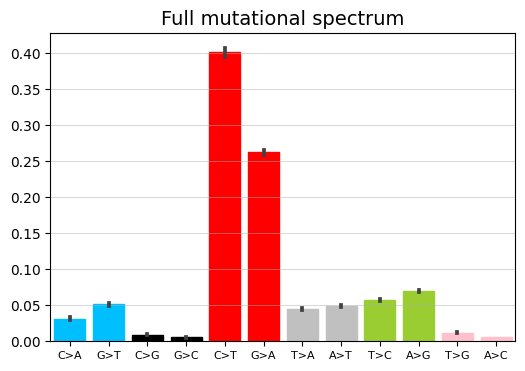

<AxesSubplot:title={'center':'Full mutational spectrum'}>

In [8]:
draw.plot_mutspec12(mutspec12, savepath='/home/gabs/Documents/lab/TermitesAndCockroaches/mtdna-mutspec-insecta/figures/midori_all_insects_mutspec/mutspec12.pdf')

findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.


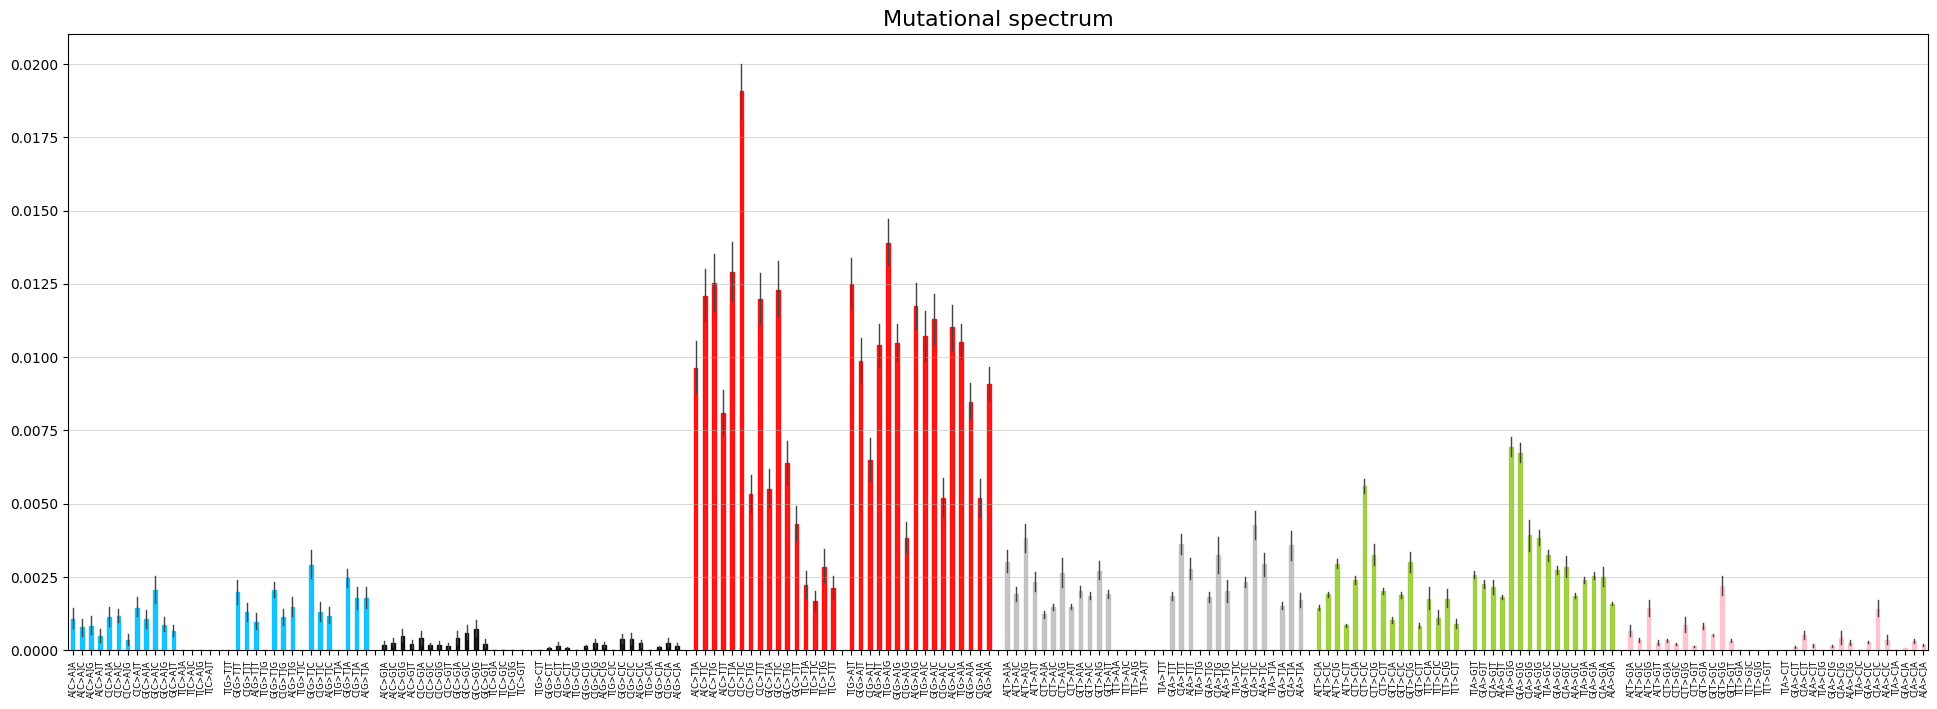

<AxesSubplot:title={'center':'Mutational spectrum'}>

In [ ]:
draw.plot_mutspec192(mutspec192, savepath='/home/gabs/Documents/lab/TermitesAndCockroaches/mtdna-mutspec-insecta/figures/midori_all_insects_mutspec/mutspec192.pdf')

### Egg vol dataset


In [35]:
eggo = pd.read_csv('/mnt/data/Documents/lab/TermitesAndCockroaches/mtdna-mutspec-insecta/data/EcoMorphDBs/egg_dataset.tsv', sep='\t')
AGms = mutspec12[mutspec12['Mut'] == 'A>G']

In [36]:
eggo['A>G'] = np.nan
for sp in AGms['Species']:
    val = AGms.loc[AGms['Species'] == sp, 'MutSpec'].to_list()[0]
    eggo.loc[eggo['name'] == sp, 'A>G'] = val
eggo = eggo[eggo['A>G'].notna()]
eggo = eggo[eggo['vol'].notna()]
eggo = eggo[['name', 'order', 'family', 'vol', 'A>G']]

In [10]:
len(eggo['name'].unique())

613

In [11]:
#drop super big and super small volumes
#eggo = eggo.loc[(np.abs(zscore(eggo['vol'])) < 3)]

In [12]:
fig = px.scatter(eggo, x='A>G', y='vol', color='order', hover_data=['name'], log_y=True, labels={'vol':'log vol'}, marginal_x='histogram', marginal_y='box', color_discrete_sequence=px.colors.qualitative.Light24, title='Correlation of egg volume and A>G')
fig.update_layout(width=1440,
    height=1024,
    )
fig.show()

In [13]:
rho, p = spearmanr(eggo['vol'], eggo['A>G'])
print(f'Total eggo spearman:\nRho --- {rho}\np-value --- {p}')

Total eggo spearman:
Rho --- 0.06906915848582747
p-value --- 0.04447675311571145


In [14]:
orders = eggo['order'].unique()
for order in orders:
    check = '(x)'
    tmp_df = eggo[eggo['order'] == order]
    if len(tmp_df) > 2:
        rho, p = spearmanr(tmp_df['vol'], tmp_df['A>G'])
        if p < 0.05:
            check = '(< 0.05)'
        print(f'{order} spearman:\nRho --- {rho}\np-value --- {p} {check}\n' + '='*42)
    else:
        print(f'Too few species species in {order}\n' +'='*42)

Blattodea spearman:
Rho --- -0.7373444023499247
p-value --- 0.01495054387657749 (< 0.05)
Coleoptera spearman:
Rho --- -0.4048337288844349
p-value --- 0.0006163683476595879 (< 0.05)
Too few species species in Dermaptera
Diptera spearman:
Rho --- 0.30412114838621024
p-value --- 0.00023365675510962956 (< 0.05)
Ephemeroptera spearman:
Rho --- -0.048706666705033756
p-value --- 0.791224048068716 (x)
Hemiptera spearman:
Rho --- 0.3064634068840905
p-value --- 0.02562217645310918 (< 0.05)
Hymenoptera spearman:
Rho --- 0.21542571093261284
p-value --- 0.09544260324909676 (x)
Lepidoptera spearman:
Rho --- 0.02042087110526543
p-value --- 0.6922869122553492 (x)
Neuroptera spearman:
Rho --- -0.5580809183750252
p-value --- 0.15056817707150397 (x)
Odonata spearman:
Rho --- -0.3714285714285715
p-value --- 0.46847813411078715 (x)
Orthoptera spearman:
Rho --- -0.19095022592010696
p-value --- 0.18875318330785537 (x)
Phasmatodea spearman:
Rho --- 0.27883397085710143
p-value --- 0.5036528556919295 (x)
Plecop

/tmp/ipykernel_19047/865207978.py:6: ConstantInputWarning:

An input array is constant; the correlation coefficient is not defined.



In [15]:
fig.write_html('/mnt/data/Documents/lab/TermitesAndCockroaches/mtdna-mutspec-insecta/figures/egg_vol_A>G_corr.html')

# Search for outliers

In [16]:
#half-assed way of converting the table into what I need
mutspec_vals = mutspec12['MutSpec'].to_list()
muts = mutspec12['Mut'].to_list()[0:12]
species = mutspec12['Species'].drop_duplicates().to_list() #need to reset after removing species

chopped_values = list(chop(mutspec_vals, 12))
df_prep = {}
for i in range(len(species)):
    df_prep[species[i]] = chopped_values[i]
df = pd.DataFrame(df_prep)
df = df.T
df.columns = muts
df = df.fillna(0)

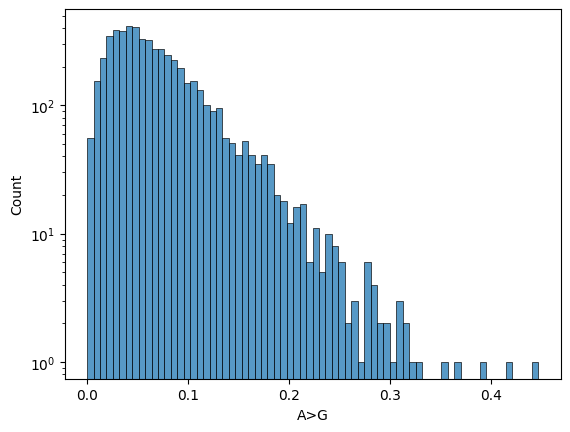

In [17]:
if INVERT == True:
    outlier_spec = df.drop(columns=['A>C', 'A>T', 'C>A', 'C>G', 'C>T', 'G>A', 'G>C', 'G>T', 'T>A', 'T>C', 'T>G'])
    sns.histplot(outlier_spec, x='A>G')
    plt.yscale('log')
else:
    outlier_spec = df.drop(columns=['A>G', 'A>C', 'A>T', 'C>A', 'C>T', 'C>G', 'G>A', 'G>C', 'G>T', 'T>A', 'T>G'])
    sns.histplot(outlier_spec, x='T>C')
    plt.yscale('log')

In [18]:
#getting top 5 smallest and largest values
def get_top5(mut, mutspec):
    top_5_small = mutspec[mut].nsmallest(n=round(len(mutspec) * 0.05))
    top_5_large = mutspec[mut].nlargest(n=round(len(mutspec) * 0.05))
    top_5_large_meta = top_5_small_meta = meta_df
    top5l = []
    top5s = []

    for sp in top_5_large.index:
        top5l.append(top_5_large_meta[top_5_large_meta['Species'] == sp])
    for sp in top_5_small.index:
        top5s.append(top_5_small_meta[top_5_small_meta['Species'] == sp])

    top_5_large_meta = pd.concat(top5l).sort_values(by=['Order', 'Family', 'Genus'])
    top_5_small_meta = pd.concat(top5s).sort_values(by=['Order', 'Family', 'Genus'])
    top_5_large_meta[mut] = top_5_small_meta[mut] = np.nan
    for sp in top_5_large.index:
        top_5_large_meta.loc[top_5_large_meta['Species'] == sp, mut] = top_5_large.loc[sp]
    for sp in top_5_small.index:
        top_5_small_meta.loc[top_5_small_meta['Species'] == sp, mut] = top_5_small.loc[sp]
    top_5_meta = pd.concat([top_5_large_meta, top_5_small_meta])

    #filter by num of species per family
    fam_counts = top_5_meta['Family'].value_counts().to_dict()
    for fam, count in fam_counts.items():
        if count < 15:
            top_5_meta = top_5_meta.drop(top_5_meta[top_5_meta['Family'] == fam].index)

    top_5_meta.to_csv(f'/mnt/data/Documents/lab/TermitesAndCockroaches/mtdna-mutspec-insecta/data/NemuPipeline/AllInsects/midori_all_insects_mutspec/ms12syn_internal_{mut}_top5largesmall.tsv', sep='\t', index=False)
    print(top_5_meta)

if INVERT == True:
    get_top5('A>G', outlier_spec)
else:
    get_top5('T>C', outlier_spec)


                       Species          Class             Order  \
544              Acalles_lemur  Insecta_50557   Coleoptera_7041   
9321   Conophthorus_ponderosae  Insecta_50557   Coleoptera_7041   
6648     Echinodera_paganettii  Insecta_50557   Coleoptera_7041   
10929       Euwallacea_validus  Insecta_50557   Coleoptera_7041   
563     Euwallacea_interjectus  Insecta_50557   Coleoptera_7041   
...                        ...            ...               ...   
9082      Diachrysia_chrysitis  Insecta_50557  Lepidoptera_7088   
10240   Helicoverpa_punctigera  Insecta_50557  Lepidoptera_7088   
5362      Lacinipolia_meditata  Insecta_50557  Lepidoptera_7088   
6924              Schinia_luxa  Insecta_50557  Lepidoptera_7088   
10842        Spodoptera_exigua  Insecta_50557  Lepidoptera_7088   

                   Family                Genus  Nodes_in_tree       A>G  
544    Curculionidae_7042       Acalles_201732           12.0  0.210532  
9321   Curculionidae_7042  Conophthorus_322464 

In [19]:
#gettin statistical outliers. In this case it's only highest values
def get_stat_outliers(mut, mutspec, meta):
    mut_outliers = mutspec[(np.abs(zscore(mutspec)) > 3).all(axis=1)]
    outliers = []
    for sp in mut_outliers.index:
        outliers.append(meta[meta['Species'] == sp])
    meta = pd.concat(outliers)

    mut_outliers = mut_outliers.sort_index()
    meta = meta.sort_values(by=['Species'])
    meta = meta.reset_index().drop(columns=['index'])
    mut_outliers = mut_outliers.reset_index().drop(columns=['index'])
    meta = pd.concat([meta, mut_outliers[mut]], axis=1)
    meta = meta.sort_values(by=[mut], ascending=False)

    meta.to_csv(f'/mnt/data/Documents/lab/TermitesAndCockroaches/mtdna-mutspec-insecta/data/NemuPipeline/AllInsects/midori_all_insects_mutspec/ms12syn_internal_{mut}outliers.tsv', sep='\t', index=False)
    print(meta)


if INVERT == True:
    get_stat_outliers('A>G', outlier_spec, meta_df)
else:
    get_stat_outliers('T>C', outlier_spec, meta_df)

                        Species          Class             Order  \
46             Machimus_notatus  Insecta_50557      Diptera_7147   
75  Trinervitermes_occidentalis  Insecta_50557   Blattodea_85823   
10            Andrena_ventralis  Insecta_50557  Hymenoptera_7399   
69           Strumigenys_rogeri  Insecta_50557  Hymenoptera_7399   
38       Hypotermes_makhamensis  Insecta_50557   Blattodea_85823   
..                          ...            ...               ...   
45          Macaria_aemulataria  Insecta_50557  Lepidoptera_7088   
64            Schizura_ipomoeae  Insecta_50557  Lepidoptera_7088   
32              Erebia_aethiops  Insecta_50557  Lepidoptera_7088   
37           Hypercompe_caudata  Insecta_50557  Lepidoptera_7088   
11   Aphaenogaster_occidentalis  Insecta_50557  Hymenoptera_7399   

                Family                 Genus  Nodes_in_tree       A>G  
46      Asilidae_50673       Machimus_247604           17.0  0.447058  
75    Termitidae_46569  Trinervitermes_

# COCK_TERM STUFF

In [6]:
metadata = pd.read_csv(PATH_TO_METADATA, sep='\t', index_col=0)
blattodea_meta = metadata.loc[metadata['Order'] == 'Blattodea_85823']

In [21]:
blattodea_meta['Family'].unique()

array(['Blattidae_6974', 'Rhinotermitidae_36985', 'Ectobiidae_1049651',
       'Termitidae_46569', 'Cryptocercidae_36982'], dtype=object)

In [7]:
terms_meta = [] 
terms_meta.append(blattodea_meta.loc[blattodea_meta['Family'] == 'Rhinotermitidae_36985'])
terms_meta.append(blattodea_meta.loc[blattodea_meta['Family'] == 'Termitidae_46569'])
terms_meta = pd.concat(terms_meta)
terms_meta.reset_index(inplace=True)

cocks_meta = []
cocks_meta.append(blattodea_meta.loc[blattodea_meta['Family'] == 'Blattidae_6974'])
cocks_meta.append(blattodea_meta.loc[blattodea_meta['Family'] == 'Cryptocercidae_36982'])
cocks_meta.append(blattodea_meta.loc[blattodea_meta['Family'] == 'Ectobiidae_1049651'])
cocks_meta = pd.concat(cocks_meta)
cocks_meta.reset_index(inplace=True)

In [41]:
blattodea_codontable = pd.read_csv(PATH_TO_CODONTABLE, index_col=0)
blattodea_codontable.loc[blattodea_codontable["Taxonomy"] == "['Eukaryota_2759', 'Arthropoda_6656', 'Insecta_50557', 'Blattodea_85823', 'Cryptocercidae_36982']",
                                        "Workers"] = 'Sub'
blattodea_codontable['Species_name'] = list(map(lambda sp: f'{sp.split("_")[0]}_{sp.split("_")[1]}', blattodea_codontable['Species_name']))
blattodea_codontable['Workers'] = blattodea_codontable['Workers'].map({1.0 : 'Termites w/ workers', 0.0 : 'Termites w/o workers', "Sub" : 'Sub-social Cryptocercus'})
blattodea_codontable['Workers'] = blattodea_codontable['Workers'].fillna('Cockroaches')

term_codontable = blattodea_codontable[blattodea_codontable['Workers'].isin(['Termites w/ workers', 'Termites w/o workers'])]

cocks_codontable = blattodea_codontable[blattodea_codontable['Workers'].isin(['Cockroaches', 'Sub-social Cryptocercus'])]

In [45]:
if INVERT == True:
    def get_codontable(codontable, organism):
        #summing for genes on negative strand
        neg_codontable = codontable.loc[(codontable['Gene_name'] == 'ND1') | (codontable['Gene_name'] == 'ND4') | (codontable['Gene_name'] == 'ND4L') | (codontable['Gene_name'] == 'ND5')]
        codontable = codontable.drop(codontable[(codontable['Gene_name'] == 'ND1') | (codontable['Gene_name'] == 'ND4') | (codontable['Gene_name'] == 'ND4L') | (codontable['Gene_name'] == 'ND5')].index)
        neg_atgc = neg_codontable.agg({'neutralA' : 'sum', 'neutralT' : 'sum', 'neutralG' : 'sum', 'neutralC' : 'sum'}).to_frame(name='count')

        #summing for genes on positive strand
        codontable = codontable.rename(columns={'neutralA' : 'neutralT', 'neutralT' : 'neutralA', 'neutralG' : 'neutralC', 'neutralC' : 'neutralG'})
        atgc_table = codontable.agg({'neutralA' : 'sum', 'neutralT' : 'sum', 'neutralG' : 'sum', 'neutralC' : 'sum'}).to_frame(name='count')
        atgc_table['count'] = atgc_table['count'] + neg_atgc['count']


        atgc_table['Organism'] = organism
        atgc_table['normalized_count'] = np.nan
        atgc_table.at['neutralA', 'normalized_count'] = atgc_table.at['neutralA', 'count'] / atgc_table['count'].sum()
        atgc_table.at['neutralT', 'normalized_count'] = atgc_table.at['neutralT', 'count'] / atgc_table['count'].sum()
        atgc_table.at['neutralG', 'normalized_count'] = atgc_table.at['neutralG', 'count'] / atgc_table['count'].sum()
        atgc_table.at['neutralC', 'normalized_count'] = atgc_table.at['neutralC', 'count'] / atgc_table['count'].sum()

        return atgc_table
else:
    def get_codontable(codontable, organism):
        #summing for genes on negative strand
        neg_codontable = codontable.rename(columns={'neutralA' : 'neutralT', 'neutralT' : 'neutralA', 'neutralG' : 'neutralC', 'neutralC' : 'neutralG'})
        codontable = codontable.drop(codontable[(codontable['Gene_name'] == 'ND1') | (codontable['Gene_name'] == 'ND4') | (codontable['Gene_name'] == 'ND4L') | (codontable['Gene_name'] == 'ND5')].index)
        neg_atgc = neg_codontable.agg({'neutralA' : 'sum', 'neutralT' : 'sum', 'neutralG' : 'sum', 'neutralC' : 'sum'}).to_frame(name='count')

        #summing for genes on positive strand
        atgc_table = codontable.agg({'neutralA' : 'sum', 'neutralT' : 'sum', 'neutralG' : 'sum', 'neutralC' : 'sum'}).to_frame(name='count')
        atgc_table['count'] = atgc_table['count']# + neg_atgc['count']


        atgc_table['Organism'] = organism
        atgc_table['normalized_count'] = np.nan
        atgc_table.at['neutralA', 'normalized_count'] = atgc_table.at['neutralA', 'count'] / atgc_table['count'].sum()
        atgc_table.at['neutralT', 'normalized_count'] = atgc_table.at['neutralT', 'count'] / atgc_table['count'].sum()
        atgc_table.at['neutralG', 'normalized_count'] = atgc_table.at['neutralG', 'count'] / atgc_table['count'].sum()
        atgc_table.at['neutralC', 'normalized_count'] = atgc_table.at['neutralC', 'count'] / atgc_table['count'].sum()

        return atgc_table

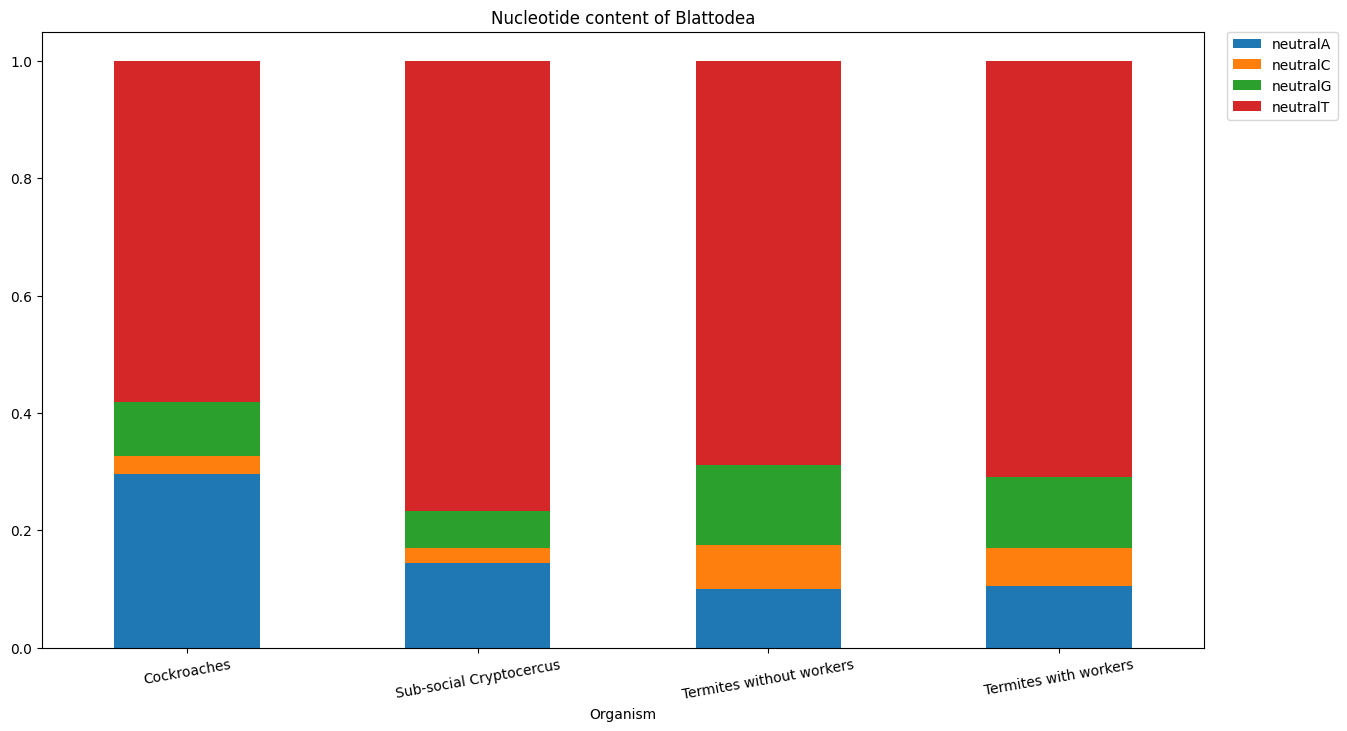

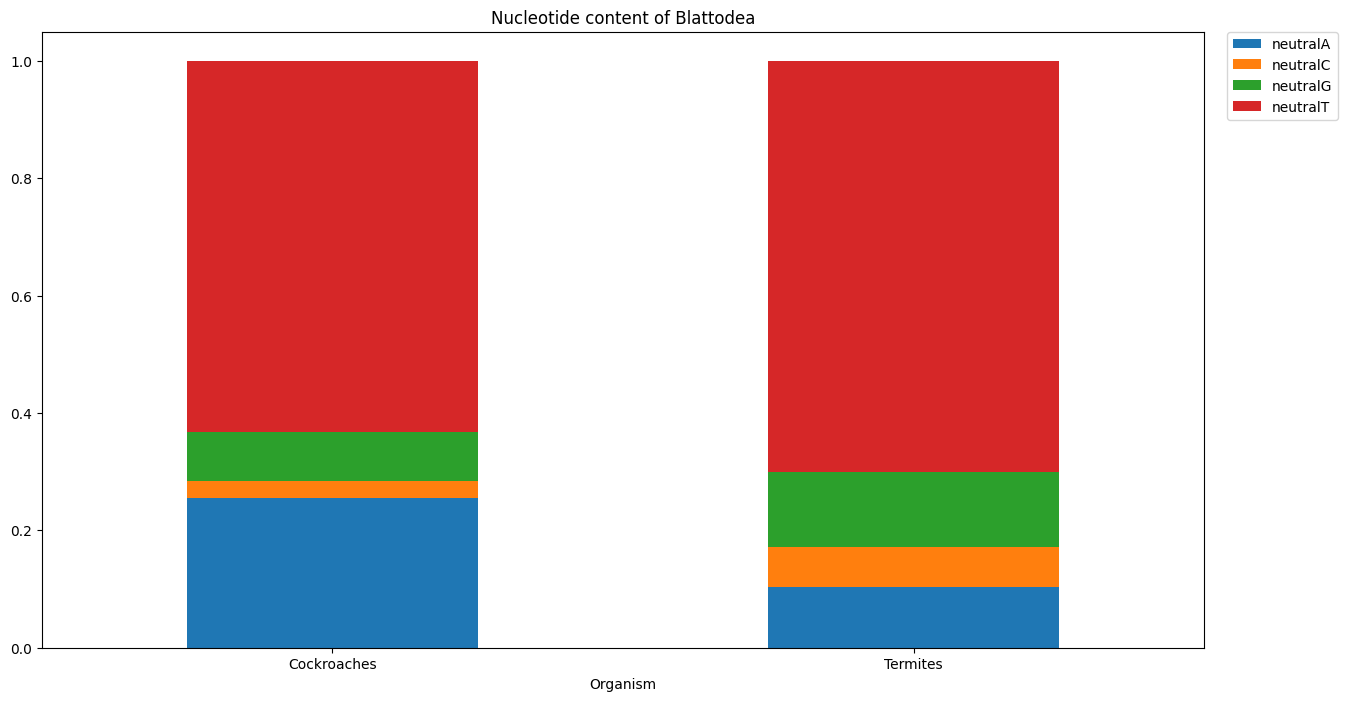

In [46]:
atgc_table = pd.concat([get_codontable(blattodea_codontable[blattodea_codontable['Workers'] == 'Cockroaches'], 'Cockroaches'), 
                        get_codontable(blattodea_codontable[blattodea_codontable['Workers'] == 'Sub-social Cryptocercus'], 'Sub-social Cryptocercus'),
                        get_codontable(blattodea_codontable[blattodea_codontable['Workers'] == 'Termites w/ workers'], 'Termites with workers'),
                        get_codontable(blattodea_codontable[blattodea_codontable['Workers'] == 'Termites w/o workers'], 'Termites without workers')])

pivoted = pd.pivot_table(atgc_table, columns=atgc_table.index, index=['Organism'])
pivoted = pivoted.drop(columns=['count'])
pivoted.columns = pivoted.columns.droplevel()
pivoted.sort_values(by=['neutralA'], ascending=False, inplace=True)
pivoted = pivoted.reindex(['Cockroaches', 'Sub-social Cryptocercus', 'Termites without workers', 'Termites with workers'])


fig = pivoted.plot(kind='bar', stacked=True)
fig.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.rcParams["figure.figsize"] = (15,8)
plt.xticks(rotation = 10)
plt.title('Nucleotide content of Blattodea')
plt.savefig('/home/gabs/Documents/lab/TermitesAndCockroaches/mtdna-mutspec-insecta/figures/NucContent_Blattodea_4grps.pdf')

atgc_table_all = pd.concat([get_codontable(cocks_codontable, 'Cockroaches'), get_codontable(term_codontable, 'Termites')])
pivoted = pd.pivot_table(atgc_table_all, columns=atgc_table_all.index, index=['Organism'])
pivoted = pivoted.drop(columns=['count'])
pivoted.columns = pivoted.columns.droplevel()

pivoted.plot(kind='bar', stacked=True)
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.rcParams["figure.figsize"] = (15,8)
plt.xticks(rotation = 0)
plt.title('Nucleotide content of Blattodea')
plt.savefig('/home/gabs/Documents/lab/TermitesAndCockroaches/mtdna-mutspec-insecta/figures/NucContent_Blattodea_2grps.pdf')

In [33]:
blattodea_codontable['Workers'].value_counts() / 13

Termites w/ workers        202.0
Termites w/o workers       129.0
Cockroaches                 48.0
Sub-social Cryptocercus     18.0
Name: Workers, dtype: float64

In [12]:
blattodea_meta.reset_index().to_csv('/mnt/data/Downloads/blattodea_metadata.csv')

In [27]:
mannwhitneyu(atgc_table_all[atgc_table_all['Organism'] == 'Cockroaches']['count'],atgc_table_all[atgc_table_all['Organism'] == 'Termites']['count'])

MannwhitneyuResult(statistic=0.0, pvalue=0.02857142857142857)

In [28]:
mannwhitneyu(atgc_table[atgc_table['Organism'] == 'Cockroaches']['count'],atgc_table[atgc_table['Organism'] == 'Termites with workers']['count'])

MannwhitneyuResult(statistic=2.0, pvalue=0.11428571428571428)

In [29]:
mannwhitneyu(atgc_table[atgc_table['Organism'] == 'Cockroaches']['count'],atgc_table[atgc_table['Organism'] == 'Termites without workers']['count'])

MannwhitneyuResult(statistic=4.0, pvalue=0.34285714285714286)

In [30]:
mannwhitneyu(atgc_table[atgc_table['Organism'] == 'Cockroaches']['count'],atgc_table[atgc_table['Organism'] == 'Sub-social Cryptocercus']['count'])

MannwhitneyuResult(statistic=13.0, pvalue=0.2)

In [31]:
#anova
f_oneway(atgc_table[atgc_table['Organism'] == 'Cockroaches']['count'],
         atgc_table[atgc_table['Organism'] == 'Sub-social Cryptocercus']['count'],
         atgc_table[atgc_table['Organism'] == 'Termites with workers']['count'],
         atgc_table[atgc_table['Organism'] == 'Termites without workers']['count'])

F_onewayResult(statistic=1.3704980709502301, pvalue=0.2988468983100153)

In [11]:
cocks_mutspec12 = []
for sp in cocks_meta['Species']:
    cocks_mutspec12.append(mutspec12.loc[mutspec12['Species'] == sp])
cocks_mutspec12 = pd.concat(cocks_mutspec12)

terms_mutspec12 = []
for sp in terms_meta['Species']:
    terms_mutspec12.append(mutspec12.loc[mutspec12['Species'] == sp])
terms_mutspec12 = pd.concat(terms_mutspec12)

In [12]:
terms_mutspec12.to_csv('/mnt/data/Documents/lab/TermitesAndCockroaches/mtdna-mutspec-insecta/data/MIDORI/term_filtered_mutspec12.csv')

In [13]:
cocks_mutspec12.to_csv('/mnt/data/Documents/lab/TermitesAndCockroaches/mtdna-mutspec-insecta/data/MIDORI/cock_filtered_mutspec12.csv')

In [14]:
cocks_TC = cocks_mutspec12[cocks_mutspec12['Mut'] == 'T>C']
term_TC = terms_mutspec12[terms_mutspec12['Mut'] == 'T>C']
cocks_AG = cocks_mutspec12[cocks_mutspec12['Mut'] == 'A>G']
term_AG = terms_mutspec12[terms_mutspec12['Mut'] == 'A>G']

In [15]:
#cosine similarity AG
x = np.array([term_AG['MutSpec'].to_list()]).T
y = np.array([cocks_AG['MutSpec'].to_list()]).T
cdist(x, y, metric='cosine')

array([[0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.]])

In [25]:
#cosine similarity CT_GA
cocks_CT_GA = cocks_mutspec12[(cocks_mutspec12['Mut'] == 'C>T') | (cocks_mutspec12['Mut'] == 'G>A')]
term_CT_GA = terms_mutspec12[(terms_mutspec12['Mut'] == 'C>T') | (terms_mutspec12['Mut'] == 'G>A')]

x = np.array([term_CT_GA['MutSpec'].to_list()]).T
y = np.array([cocks_CT_GA['MutSpec'].to_list()]).T
cdist(x, y, metric='cosine')

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.,

In [30]:
#cosine similarity CT vs GA
cocks_CT = cocks_mutspec12[(cocks_mutspec12['Mut'] == 'C>T')]
cocsk_GA = cocks_mutspec12[(cocks_mutspec12['Mut'] == 'G>A')]
term_CT = terms_mutspec12[(terms_mutspec12['Mut'] == 'C>T')]
term_GA = terms_mutspec12[(terms_mutspec12['Mut'] == 'G>A')]

x = np.array([cocks_CT['MutSpec'].to_list()]).T
y = np.array([cocsk_GA['MutSpec'].to_list()]).T
print(cdist(x, y, metric='cosine'))

x = np.array([term_CT['MutSpec'].to_list()]).T
y = np.array([term_GA['MutSpec'].to_list()]).T
print(cdist(x, y, metric='cosine'))

[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
[[0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]]


In [37]:
ttest_ind(term_TC['MutSpec'], cocks_TC['MutSpec'])

TtestResult(statistic=1.419870269604129, pvalue=0.1791799527146793, df=13.0)

In [36]:
ttest_ind(term_AG['MutSpec'], cocks_AG['MutSpec'])

TtestResult(statistic=2.6724390779640284, pvalue=0.019175049290522037, df=13.0)

In [37]:
mannwhitneyu(term_AG['MutSpec'], cocks_AG['MutSpec'])

MannwhitneyuResult(statistic=48.0, pvalue=0.011988011988011988)

In [38]:
mannwhitneyu(term_TC['MutSpec'], cocks_TC['MutSpec'])

MannwhitneyuResult(statistic=36.0, pvalue=0.3276723276723276)

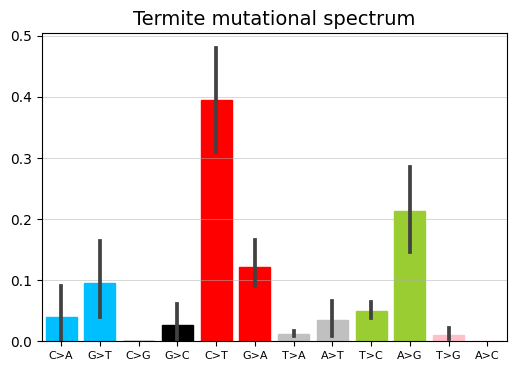

<AxesSubplot:title={'center':'Termite mutational spectrum'}>

In [38]:
draw.plot_mutspec12(terms_mutspec12, title='Termite mutational spectrum', savepath='/home/gabs/Documents/lab/TermitesAndCockroaches/mtdna-mutspec-insecta/figures/term_ms12.pdf')


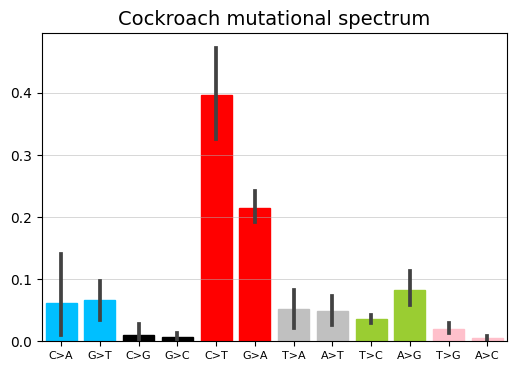

<AxesSubplot:title={'center':'Cockroach mutational spectrum'}>

In [39]:
draw.plot_mutspec12(cocks_mutspec12, title='Cockroach mutational spectrum', savepath='/home/gabs/Documents/lab/TermitesAndCockroaches/mtdna-mutspec-insecta/figures/cock_ms12.pdf')

# New TermCock data


In [95]:
blattodea_meta = pd.read_csv('/home/gabs/Documents/lab/TermitesAndCockroaches/mtdna-mutspec-insecta/data/NemuPipeline/TermAndCock/new_term_cock_ms/msMetaData.tsv', 
                             sep='\t')
cock_ter_mutspec12 = pd.read_csv('/home/gabs/Documents/lab/TermitesAndCockroaches/mtdna-mutspec-insecta/data/NemuPipeline/TermAndCock/new_term_cock_ms/ms12syn_iqtree.tsv',
                                 sep='\t')

cock_ter_mutspec192 = pd.read_csv('/home/gabs/Documents/lab/TermitesAndCockroaches/mtdna-mutspec-insecta/data/NemuPipeline/TermAndCock/new_term_cock_ms/ms192syn_iqtree.tsv', sep='\t')

if INVERT == True:
    cock_ter_mutspec12 = inverter(cock_ter_mutspec12)
    cock_ter_mutspec192['Mut'] = cock_ter_mutspec192['Mut'].apply(inverter192)
if FILTER == True:
    cock_ter_mutspec12, blattodea_meta = filter(cock_ter_mutspec12, blattodea_meta, 
                                                at_least_n_muts=10, filter_mut_types=False)
    #cock_ter_mutspec192, blattodea_meta = filter(cock_ter_mutspec192, blattodea_meta,
    #at_least_n_muts=15, filter_mut_types=False)

terms_meta = [] 
terms_meta.append(blattodea_meta.loc[blattodea_meta['Family'] == 'Rhinotermitidae'])
terms_meta.append(blattodea_meta.loc[blattodea_meta['Family'] == 'Termitidae'])
terms_meta.append(blattodea_meta.loc[blattodea_meta['Family'] == 'Hodotermitidae'])
terms_meta = pd.concat(terms_meta)
terms_meta.reset_index(inplace=True)

cocks_meta = []
cocks_meta.append(blattodea_meta.loc[blattodea_meta['Family'] == 'Blattidae'])
cocks_meta.append(blattodea_meta.loc[blattodea_meta['Family'] == 'Cryptocercidae'])
cocks_meta.append(blattodea_meta.loc[blattodea_meta['Family'] == 'Ectobiidae'])
cocks_meta.append(blattodea_meta.loc[blattodea_meta['Family'] == 'Corydiidae'])
cocks_meta.append(blattodea_meta.loc[blattodea_meta['Family'] == 'Blaberidae'])
cocks_meta = pd.concat(cocks_meta)
cocks_meta.reset_index(inplace=True)

cocks_mutspec12 = []
cocks_mutspec192 = []
for sp in cocks_meta['Species']:
    cocks_mutspec12.append(cock_ter_mutspec12.loc[cock_ter_mutspec12['Species'] == sp])
    cocks_mutspec192.append(cock_ter_mutspec192.loc[cock_ter_mutspec192['Species'] == sp])
cocks_mutspec12 = pd.concat(cocks_mutspec12)
cocks_mutspec192 = pd.concat(cocks_mutspec192)

terms_mutspec12 = []
terms_mutspec192 = []
for sp in terms_meta['Species']:
    terms_mutspec12.append(cock_ter_mutspec12.loc[cock_ter_mutspec12['Species'] == sp])
    terms_mutspec192.append(cock_ter_mutspec192.loc[cock_ter_mutspec192['Species'] == sp])
terms_mutspec12 = pd.concat(terms_mutspec12)
terms_mutspec192 = pd.concat(terms_mutspec192)

In [98]:
cocks_meta

,index,Species,Class,Order,Family,Genus,Nodes_in_tree
0,5,Celatoblatta_vulgaris,Insecta,Blattodea,Blattidae,Celatoblatta,4
1,16,Bundoksia_longissima,Insecta,Blattodea,Blattidae,Bundoksia,13
2,21,Celatoblatta_montana,Insecta,Blattodea,Blattidae,Celatoblatta,3
3,8,Cryptocercus_punctulatus,Insecta,Blattodea,Cryptocercidae,Cryptocercus,154
4,3,Blattella_nipponica,Insecta,Blattodea,Ectobiidae,Blattella,14
5,9,Blattella_lituricollis,Insecta,Blattodea,Ectobiidae,Blattella,16
6,11,Margattea_bisignata,Insecta,Blattodea,Ectobiidae,Margattea,10
7,22,Sigmella_schenklingi,Insecta,Blattodea,Ectobiidae,Sigmella,97
8,10,Arenivaga_floridensis,Insecta,Blattodea,Corydiidae,Arenivaga,33
9,14,Rhabdoblatta_marginata,Insecta,Blattodea,Blaberidae,Rhabdoblatta,14


In [99]:
terms_meta

,index,Species,Class,Order,Family,Genus,Nodes_in_tree
0,0,Reticulitermes_banyulensis,Insecta,Blattodea,Rhinotermitidae,Reticulitermes,17
1,15,Heterotermes_tenuis,Insecta,Blattodea,Rhinotermitidae,Heterotermes,3
2,18,Reticulitermes_flavipes,Insecta,Blattodea,Rhinotermitidae,Reticulitermes,4
3,19,Coptotermes_lacteus,Insecta,Blattodea,Rhinotermitidae,Coptotermes,7
4,23,Coptotermes_acinaciformis,Insecta,Blattodea,Rhinotermitidae,Coptotermes,61
5,1,Macrotermes_subhyalinus,Insecta,Blattodea,Termitidae,Macrotermes,4
6,2,Trinervitermes_geminatus,Insecta,Blattodea,Termitidae,Trinervitermes,17
7,6,Embiratermes_neotenicus,Insecta,Blattodea,Termitidae,Embiratermes,3
8,24,Nasutitermes_kemneri,Insecta,Blattodea,Termitidae,Nasutitermes,12
9,27,Odontotermes_latericius,Insecta,Blattodea,Termitidae,Odontotermes,3


In [59]:
cocks_mutspec12

,Species,Mut,ObsNum,ExpNum,MutSpec
66,Celatoblatta_vulgaris,A>C,0.00000,25.3182,0.000000
65,Celatoblatta_vulgaris,A>G,4.62151,100.0650,0.027192
64,Celatoblatta_vulgaris,A>T,0.91885,25.3182,0.021367
71,Celatoblatta_vulgaris,C>A,0.00000,1.4892,0.000000
67,Celatoblatta_vulgaris,C>G,0.00000,1.4892,0.000000
...,...,...,...,...,...
311,Geoscapheus_dilatatus,G>C,0.00000,20.0126,0.000000
303,Geoscapheus_dilatatus,G>T,2.38375,20.0126,0.024060
302,Geoscapheus_dilatatus,T>A,12.19010,123.7350,0.019900
301,Geoscapheus_dilatatus,T>C,48.35850,229.3590,0.042589


In [27]:
terms_mutspec192

,Species,Mut,ObsNum,ExpNum,MutSpec
0,Reticulitermes_banyulensis,T[G>A]G,1.982980,3.62381,0.130415
1,Reticulitermes_banyulensis,T[G>A]A,0.998310,14.98960,0.015873
2,Reticulitermes_banyulensis,T[A>G]C,0.923752,1.49561,0.147202
3,Reticulitermes_banyulensis,T[A>G]A,0.952665,4.55695,0.049824
4,Reticulitermes_banyulensis,G[T>C]G,0.841071,4.67728,0.000000
...,...,...,...,...,...
2491,Trinervitermes_occidentalis,A[C>G]G,0.000000,2.00000,0.000000
2492,Trinervitermes_occidentalis,A[G>T]T,0.000000,3.00000,0.000000
2493,Trinervitermes_occidentalis,A[G>C]G,0.000000,2.00000,0.000000
2494,Trinervitermes_occidentalis,C[C>G]A,0.000000,0.00000,0.000000


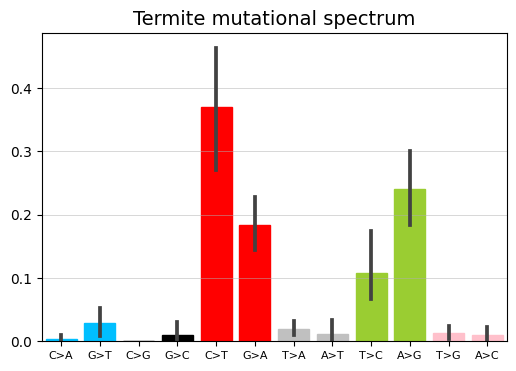

<AxesSubplot:title={'center':'Termite mutational spectrum'}>

In [93]:
draw.plot_mutspec12(terms_mutspec12, title='Termite mutational spectrum')


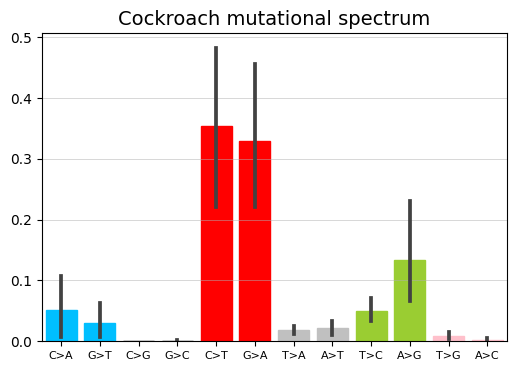

<AxesSubplot:title={'center':'Cockroach mutational spectrum'}>

In [94]:
draw.plot_mutspec12(cocks_mutspec12, title='Cockroach mutational spectrum')

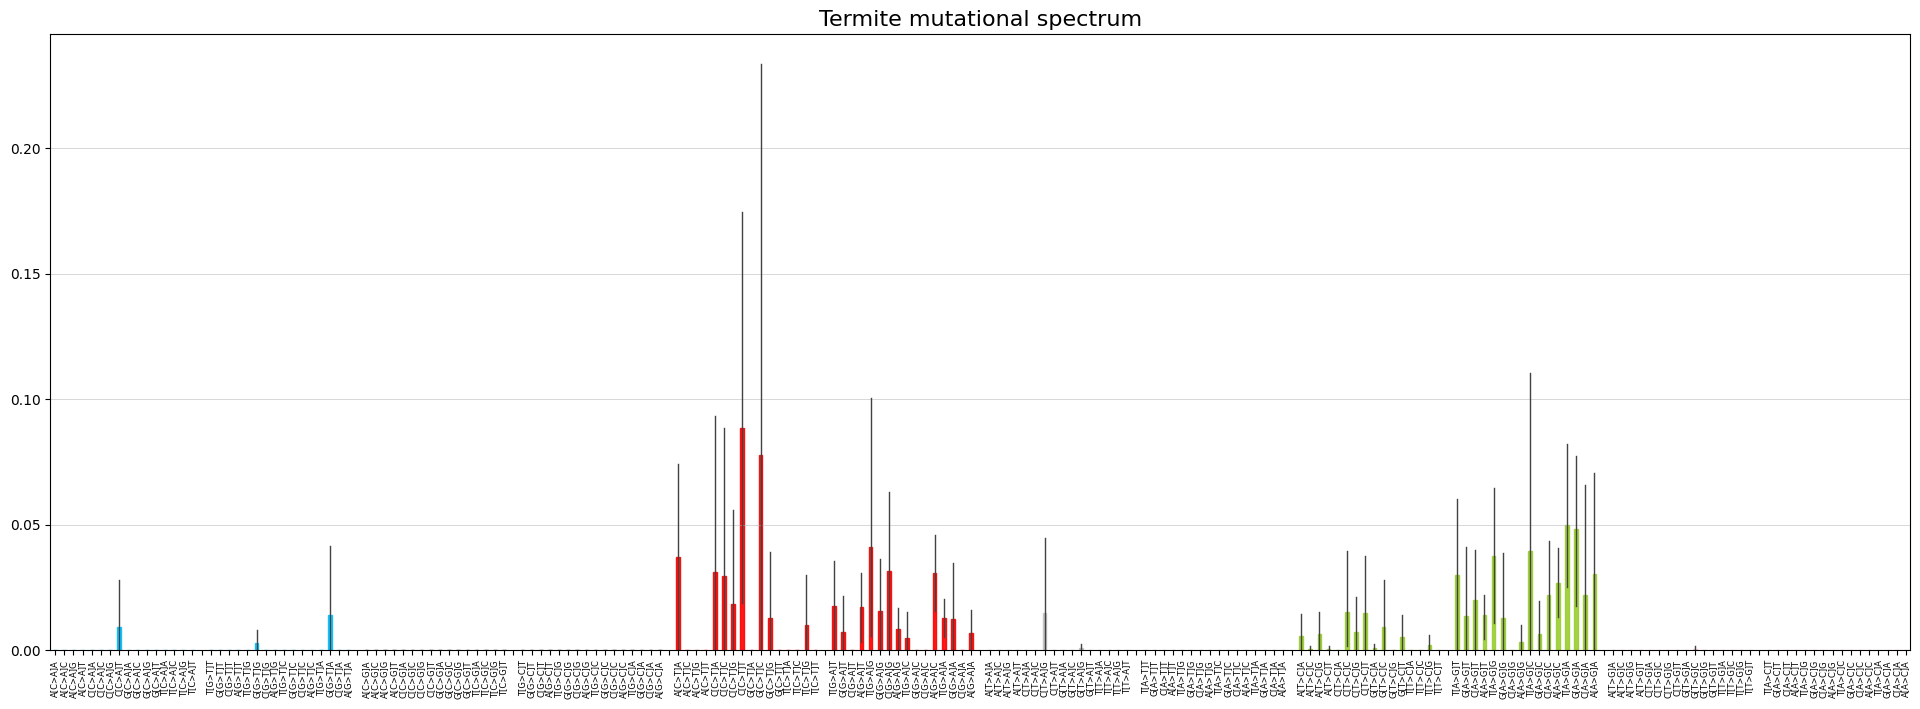

<AxesSubplot:title={'center':'Termite mutational spectrum'}>

In [30]:
draw.plot_mutspec192(terms_mutspec192, title='Termite mutational spectrum')

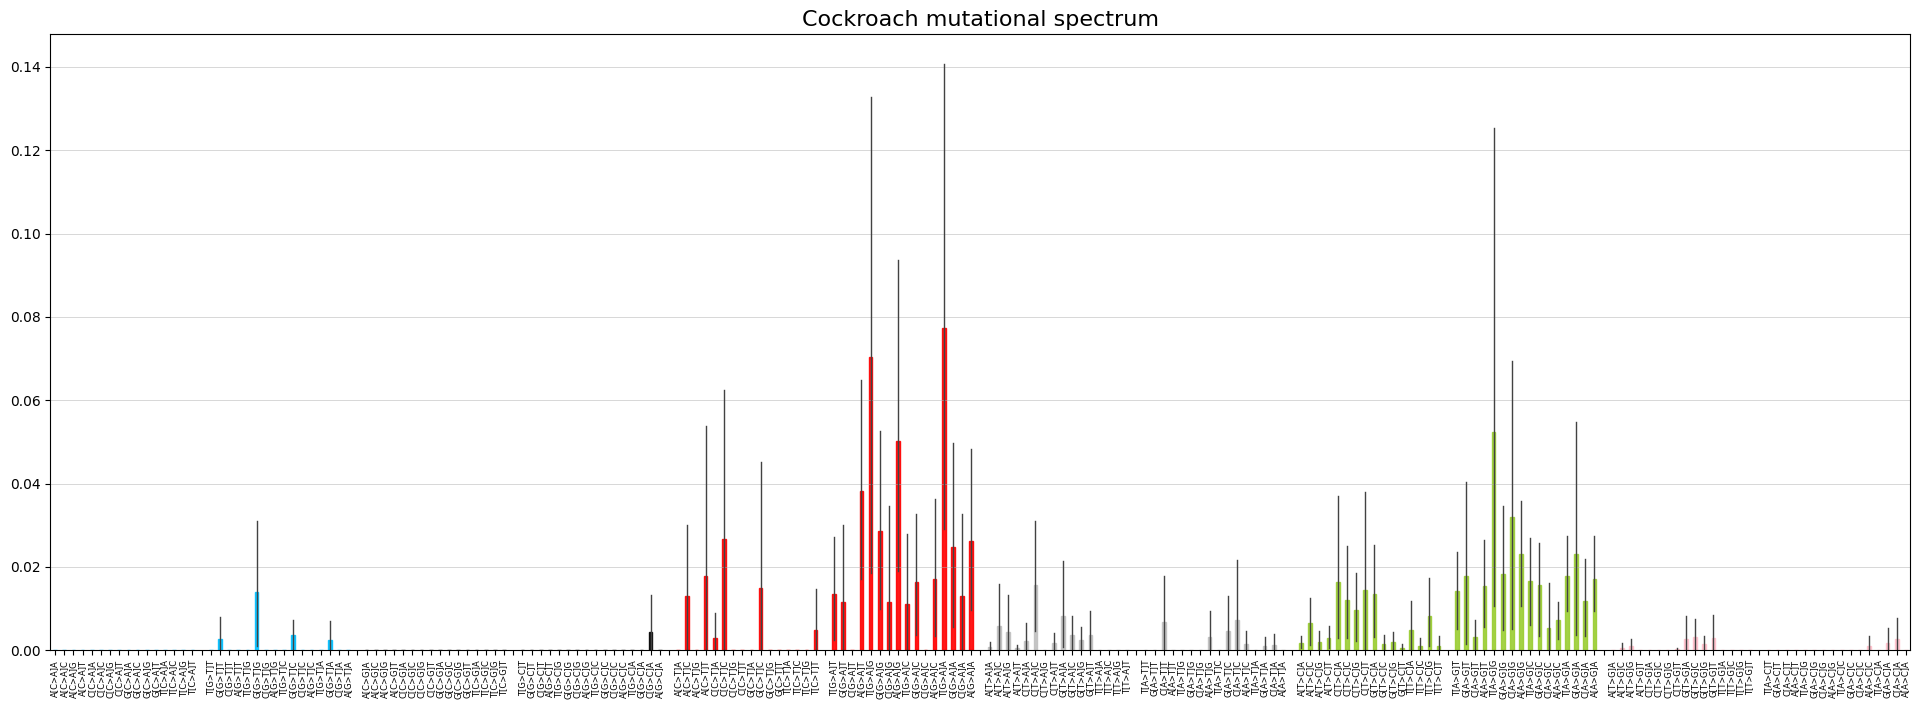

<AxesSubplot:title={'center':'Cockroach mutational spectrum'}>

In [31]:
draw.plot_mutspec192(cocks_mutspec192, title='Cockroach mutational spectrum')

In [13]:
cocks_TC = cocks_mutspec12[cocks_mutspec12['Mut'] == 'T>C']
term_TC = terms_mutspec12[terms_mutspec12['Mut'] == 'T>C']
cocks_AG = cocks_mutspec12[cocks_mutspec12['Mut'] == 'A>G']
term_AG = terms_mutspec12[terms_mutspec12['Mut'] == 'A>G']

In [14]:
#cosine similarity AG
x = np.array([term_AG['MutSpec'].to_list()]).T
y = np.array([cocks_AG['MutSpec'].to_list()]).T
cdist(x, y, metric='cosine')

array([[0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.]])

In [15]:
#cosine similarity CT_GA
cocks_CT_GA = cocks_mutspec12[(cocks_mutspec12['Mut'] == 'C>T') | (cocks_mutspec12['Mut'] == 'G>A')]
term_CT_GA = terms_mutspec12[(terms_mutspec12['Mut'] == 'C>T') | (terms_mutspec12['Mut'] == 'G>A')]

x = np.array([term_CT_GA['MutSpec'].to_list()]).T
y = np.array([cocks_CT_GA['MutSpec'].to_list()]).T
cdist(x, y, metric='cosine')

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [16]:
#cosine similarity CT vs GA
cocks_CT = cocks_mutspec12[(cocks_mutspec12['Mut'] == 'C>T')]
cocsk_GA = cocks_mutspec12[(cocks_mutspec12['Mut'] == 'G>A')]
term_CT = terms_mutspec12[(terms_mutspec12['Mut'] == 'C>T')]
term_GA = terms_mutspec12[(terms_mutspec12['Mut'] == 'G>A')]

x = np.array([cocks_CT['MutSpec'].to_list()]).T
y = np.array([cocsk_GA['MutSpec'].to_list()]).T
print(cdist(x, y, metric='cosine'))

x = np.array([term_CT['MutSpec'].to_list()]).T
y = np.array([term_GA['MutSpec'].to_list()]).T
print(cdist(x, y, metric='cosine'))

[[0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]]
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]


In [17]:
ttest_ind(term_TC['MutSpec'], cocks_TC['MutSpec'])

TtestResult(statistic=1.1305913758246606, pvalue=0.28461382059874496, df=10.0)

In [18]:
ttest_ind(term_AG['MutSpec'], cocks_AG['MutSpec'])

TtestResult(statistic=5.7091616661602, pvalue=0.00019582700669109617, df=10.0)

In [20]:
mannwhitneyu(term_TC['MutSpec'], cocks_TC['MutSpec'])

MannwhitneyuResult(statistic=20.0, pvalue=0.5696969696969697)

In [19]:
mannwhitneyu(term_AG['MutSpec'], cocks_AG['MutSpec'])

MannwhitneyuResult(statistic=32.0, pvalue=0.00404040404040404)

In [ ]:
mannwhitneyu(cocks_mutspec12[cocks_mutspec12['Mut'] == 'T>C']['MutSpec'], terms_mutspec12[terms_mutspec12['Mut'] == 'T>C']['MutSpec'])

MannwhitneyuResult(statistic=12.0, pvalue=0.5696969696969697)

In [51]:
mut_types = ['A>C', 'A>G', 'A>T', 'C>A', 'C>G', 'C>T', 'G>A', 'G>C', 'G>T', 'T>A', 'T>C', 'T>G']
tests_results = []
for mut in mut_types:
    cock_med = cocks_mutspec12[cocks_mutspec12['Mut'] == mut]['MutSpec'].median()
    ter_med = terms_mutspec12[terms_mutspec12['Mut'] == mut]['MutSpec'].median()
    t_res = ttest_ind(cocks_mutspec12[cocks_mutspec12['Mut'] == mut]['MutSpec'], terms_mutspec12[terms_mutspec12['Mut'] == mut]['MutSpec'])
    tests_results.append({'Mut' : mut, 'Test' : 't-test', 'p-val' : t_res.pvalue, 'cockroaches median' : cock_med, 'termites median' : ter_med})
    mannwhit_res = mannwhitneyu(cocks_mutspec12[cocks_mutspec12['Mut'] == mut]['MutSpec'], terms_mutspec12[terms_mutspec12['Mut'] == mut]['MutSpec'])
    tests_results.append({'Mut' : mut, 'Test' : 'mannwhitney', 'p-val' : mannwhit_res.pvalue, 'cockroaches median' : cock_med, 'termites median' : ter_med})

tests_results = pd.DataFrame(tests_results)
tests_results.sort_values(['Test', 'Mut'], ascending=[False, True]).to_csv('/home/gabs/Documents/lab/TermitesAndCockroaches/mtdna-mutspec-insecta/data/NemuPipeline/TermAndCock/new_term_cock_ms/tests_results.tsv', sep='\t')

In [52]:
tests_results.sort_values(['Test', 'Mut'], ascending=[False, True])

,Mut,Test,p-val,cockroaches median,termites median
0,A>C,t-test,0.202886,0.000000,0.000000
2,A>G,t-test,0.000196,0.108615,0.323364
4,A>T,t-test,0.117406,0.017100,0.000000
6,C>A,t-test,0.571534,0.000000,0.000000
8,C>G,t-test,NaN,0.000000,0.000000
10,C>T,t-test,0.929741,0.320230,0.370729
12,G>A,t-test,0.112608,0.303067,0.179424
14,G>C,t-test,0.505852,0.000000,0.000000
16,G>T,t-test,0.753721,0.015717,0.014088
18,T>A,t-test,0.020736,0.028933,0.003414


# Latest termcock

In [6]:
PATH_TO_FOLDER = '/home/gabs/Documents/lab/TermitesAndCockroaches/mtdna-mutspec-insecta/data/NemuPipeline/TermAndCock/'
ter_mi = pd.read_csv(f'{PATH_TO_FOLDER}latest_ter_midori_ms/filtered_ms12syn_iqtree.tsv', sep='\t').sort_values(by=['Species', 'Mut'])
nonter_mi = pd.read_csv(f'{PATH_TO_FOLDER}latest_nonter_midori_ms/filtered_ms12syn_iqtree.tsv', sep='\t').sort_values(by=['Species', 'Mut'])
ter_meta = pd.read_csv(f'{PATH_TO_FOLDER}latest_ter_midori_ms/msMetaData.tsv', sep='\t').sort_values(by=['Species'])
nonter_meta = pd.read_csv(f'{PATH_TO_FOLDER}latest_nonter_midori_ms/msMetaData.tsv', sep='\t').sort_values(by=['Species'])

ter_mi = ter_mi.dropna()
nonter_mi = nonter_mi.dropna()

if INVERT == True:
    ter_mi = inverter(ter_mi)
    nonter_mi = inverter(nonter_mi)

if FILTER == True:
    ter_mi, ter_meta = filter(ter_mi, ter_meta, at_least_n_muts=10, filter_mut_types=False)
    nonter_mi, nonter_meta = filter(nonter_mi, nonter_meta, at_least_n_muts=10, filter_mut_types=False)

In [7]:
print(len(ter_mi)/12)
print(len(nonter_mi)/12)

20.0
20.0


findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.


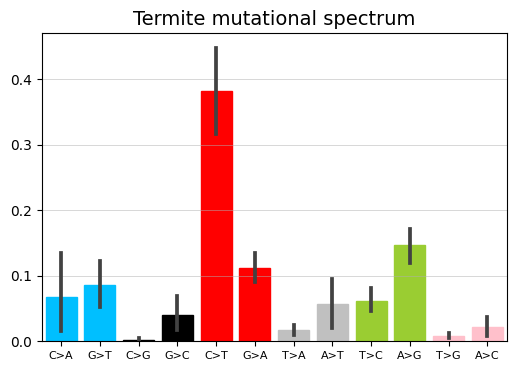

<AxesSubplot:title={'center':'Termite mutational spectrum'}>

In [8]:
draw.plot_mutspec12(ter_mi, title='Termite mutational spectrum')

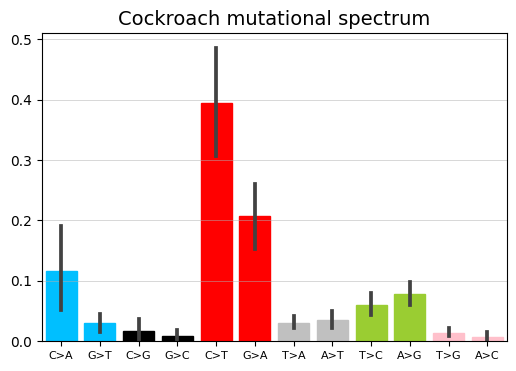

<AxesSubplot:title={'center':'Cockroach mutational spectrum'}>

In [9]:
draw.plot_mutspec12(nonter_mi, title='Cockroach mutational spectrum')

In [10]:
cocks_mutspec12 = nonter_mi
terms_mutspec12 = ter_mi

In [11]:
cocks_TC = cocks_mutspec12[cocks_mutspec12['Mut'] == 'T>C']
term_TC = terms_mutspec12[terms_mutspec12['Mut'] == 'T>C']
cocks_AG = cocks_mutspec12[cocks_mutspec12['Mut'] == 'A>G']
term_AG = terms_mutspec12[terms_mutspec12['Mut'] == 'A>G']

In [12]:
#cosine similarity AG
x = np.array([term_AG['MutSpec'].to_list()]).T
y = np.array([cocks_AG['MutSpec'].to_list()]).T
cdist(x, y, metric='cosine')

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.

In [13]:
#cosine similarity CT_GA
cocks_CT_GA = cocks_mutspec12[(cocks_mutspec12['Mut'] == 'C>T') | (cocks_mutspec12['Mut'] == 'G>A')]
term_CT_GA = terms_mutspec12[(terms_mutspec12['Mut'] == 'C>T') | (terms_mutspec12['Mut'] == 'G>A')]

x = np.array([term_CT_GA['MutSpec'].to_list()]).T
y = np.array([cocks_CT_GA['MutSpec'].to_list()]).T
cdist(x, y, metric='cosine')

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [14]:
#cosine similarity CT vs GA
cocks_CT = cocks_mutspec12[(cocks_mutspec12['Mut'] == 'C>T')]
cocsk_GA = cocks_mutspec12[(cocks_mutspec12['Mut'] == 'G>A')]
term_CT = terms_mutspec12[(terms_mutspec12['Mut'] == 'C>T')]
term_GA = terms_mutspec12[(terms_mutspec12['Mut'] == 'G>A')]

x = np.array([cocks_CT['MutSpec'].to_list()]).T
y = np.array([cocsk_GA['MutSpec'].to_list()]).T
print(cdist(x, y, metric='cosine'))

x = np.array([term_CT['MutSpec'].to_list()]).T
y = np.array([term_GA['MutSpec'].to_list()]).T
print(cdist(x, y, metric='cosine'))

[[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.]
 [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.

In [15]:
ttest_ind(term_TC['MutSpec'], cocks_TC['MutSpec'])

TtestResult(statistic=0.08755996555082016, pvalue=0.9306862230810773, df=38.0)

In [16]:
ttest_ind(term_AG['MutSpec'], cocks_AG['MutSpec'])

TtestResult(statistic=4.040834971560774, pvalue=0.0002501191326693206, df=38.0)

In [17]:
mannwhitneyu(term_TC['MutSpec'], cocks_TC['MutSpec'])

MannwhitneyuResult(statistic=201.0, pvalue=0.9892089047911196)

In [18]:
mannwhitneyu(term_AG['MutSpec'], cocks_AG['MutSpec'])

MannwhitneyuResult(statistic=330.0, pvalue=0.0004600727270090418)

In [19]:
mannwhitneyu(cocks_mutspec12[cocks_mutspec12['Mut'] == 'T>C']['MutSpec'], terms_mutspec12[terms_mutspec12['Mut'] == 'T>C']['MutSpec'])

MannwhitneyuResult(statistic=199.0, pvalue=0.9892089047911196)

In [20]:
mut_types = ['A>C', 'A>G', 'A>T', 'C>A', 'C>G', 'C>T', 'G>A', 'G>C', 'G>T', 'T>A', 'T>C', 'T>G']
tests_results = []
for mut in mut_types:
    cock_med = cocks_mutspec12[cocks_mutspec12['Mut'] == mut]['MutSpec'].median()
    ter_med = terms_mutspec12[terms_mutspec12['Mut'] == mut]['MutSpec'].median()
    t_res = ttest_ind(cocks_mutspec12[cocks_mutspec12['Mut'] == mut]['MutSpec'], terms_mutspec12[terms_mutspec12['Mut'] == mut]['MutSpec'])
    tests_results.append({'Mut' : mut, 'Test' : 't-test', 'p-val' : t_res.pvalue, 'cockroaches median' : cock_med, 'termites median' : ter_med})
    mannwhit_res = mannwhitneyu(cocks_mutspec12[cocks_mutspec12['Mut'] == mut]['MutSpec'], terms_mutspec12[terms_mutspec12['Mut'] == mut]['MutSpec'])
    tests_results.append({'Mut' : mut, 'Test' : 'mannwhitney', 'p-val' : mannwhit_res.pvalue, 'cockroaches median' : cock_med, 'termites median' : ter_med})

tests_results = pd.DataFrame(tests_results)

In [21]:
tests_results.sort_values(['Test', 'Mut'], ascending=[False, True])

,Mut,Test,p-val,cockroaches median,termites median
0,A>C,t-test,0.084719,0.000000,0.000000
2,A>G,t-test,0.000250,0.073949,0.156982
4,A>T,t-test,0.337979,0.026447,0.000000
6,C>A,t-test,0.306260,0.028280,0.000000
8,C>G,t-test,0.087906,0.000000,0.000000
10,C>T,t-test,0.841386,0.410095,0.397320
12,G>A,t-test,0.003120,0.185693,0.107870
14,G>C,t-test,0.032285,0.000000,0.000000
16,G>T,t-test,0.011251,0.009922,0.061639
18,T>A,t-test,0.038899,0.027662,0.011530


## Sup table 1

In [22]:
pivot_ter = ter_mi.pivot(index='Species', columns='Mut',  values=["MutSpec", "ObsNum"])
#Flatten levels
pivot_ter.columns = [f"{mut}_{stat}" for stat, mut in pivot_ter.columns]
pivot_ter = pivot_ter.reset_index()
pivot_ter.insert(1, 'Organism', 'termite')

pivot_cock = nonter_mi.pivot(index='Species', columns='Mut',  values=["MutSpec", "ObsNum"])
#Flatten levels
pivot_cock.columns = [f"{mut}_{stat}" for stat, mut in pivot_cock.columns]
pivot_cock = pivot_cock.reset_index()
pivot_cock.insert(1, 'Organism', 'cockroach')
sup_table = pd.concat([pivot_ter, pivot_cock])
sup_table.to_csv('/home/gabs/Documents/lab/TermitesAndCockroaches/mtdna-mutspec-insecta/data/NemuPipeline/TermAndCock/sup_ms.tsv', sep='\t')
sup_table

,Species,Organism,A>C_MutSpec,A>G_MutSpec,A>T_MutSpec,C>A_MutSpec,C>G_MutSpec,C>T_MutSpec,G>A_MutSpec,G>C_MutSpec,...,A>T_ObsNum,C>A_ObsNum,C>G_ObsNum,C>T_ObsNum,G>A_ObsNum,G>C_ObsNum,G>T_ObsNum,T>A_ObsNum,T>C_ObsNum,T>G_ObsNum
0,Anacanthotermes_ochraceus,termite,0.081589,0.021584,0.237921,0.084014,0.000000,0.303551,0.050928,0.000000,...,5.711995,0.980930,0.000000,4.441859,6.350262,0.000000,3.885367,2.244436,7.778324,1.411207
1,Ancistrotermes_pakistanicus,termite,0.000000,0.134966,0.000000,0.197637,0.000000,0.421019,0.028264,0.122334,...,0.000000,0.999990,0.000000,2.957611,0.974089,0.999980,0.000000,0.000000,2.974860,0.999980
2,Anoplotermes_janus,termite,0.000000,0.081421,0.114579,0.000000,0.000000,0.509408,0.077831,0.000000,...,1.998428,0.000000,0.000000,3.223805,2.506303,0.000000,0.773485,1.919889,2.565419,0.000000
3,Compositermes_vindai,termite,0.031466,0.153103,0.000000,0.000000,0.000000,0.488657,0.163124,0.000000,...,0.000000,0.000000,0.000000,2.891445,6.414147,0.000000,0.941842,0.640454,4.435438,0.821346
4,Coptotermes_acinaciformis,termite,0.044275,0.204442,0.000000,0.041670,0.000000,0.400227,0.138459,0.085872,...,0.000000,0.969210,0.000000,15.880835,50.330301,4.908900,1.705588,5.257279,21.256318,3.473767
5,Coptotermes_frenchi,termite,0.000000,0.176479,0.000000,0.000000,0.000000,0.144254,0.197571,0.220802,...,0.000000,0.000000,0.000000,0.485206,5.466781,0.999977,0.931694,0.927259,1.138932,0.000000
6,Coptotermes_gestroi,termite,0.088490,0.160861,0.176905,0.000000,0.000000,0.227595,0.085310,0.076153,...,1.998431,0.000000,0.000000,2.609747,6.200373,0.999641,1.999261,0.000000,3.297954,0.305881
7,Coptotermes_heimi,termite,0.062691,0.168292,0.215842,0.000000,0.000000,0.084705,0.077597,0.000000,...,3.262569,0.000000,0.000000,0.960428,3.844924,0.000000,2.834284,3.779603,2.885354,0.854686
8,Heterotermes_tenuis,termite,0.000000,0.169590,0.000000,0.130117,0.000000,0.384923,0.116010,0.047877,...,0.000000,0.999969,0.000000,5.250884,8.430794,0.953885,0.852420,0.854491,9.480650,0.861906
9,Macrotermes_subhyalinus,termite,0.000000,0.205325,0.045996,0.000000,0.000000,0.394414,0.115610,0.034368,...,0.943660,0.000000,0.000000,5.170025,11.358075,0.782098,3.688772,0.885946,3.765369,0.999965


# DIPTERA STUFF
  TODO: 
- ~~Add INVERTED trigger~~
- ~~Add ND1,ND4,ND4L,ND5 mondatory inversion (first check if diptera have them on negative strand, most likely it is, checks out in drosophila melanogaster)~~

In [42]:
PATH_TO_CODONTABLE = f'/home/gabs/Documents/lab/TermitesAndCockroaches/mtdna-mutspec-insecta/data/DescriptiveStat/codontable_midori_Diptera.csv'
metadata = pd.read_csv(PATH_TO_METADATA, sep='\t', index_col=0)
diptera_meta = metadata.loc[metadata['Order'] == 'Diptera_7147']

In [43]:
for sp in strand_check['species']:
    diptera_meta = diptera_meta.drop(diptera_meta.iloc[diptera_meta.index == sp].index)

In [44]:
nematocera_meta = [] 
families = ['Anisopodidae_52748','Bibionidae_52729','Cecidomyiidae_33406','Ceratopogonidae_41819','Chaoboridae_41811','Chironomidae_7149','Culicidae_7157','Keroplatidae_58254',
            'Limoniidae_43823','Mycetophilidae_29035','Psychodidae_7197','Ptychopteridae_79304','Sciaridae_7184','Simuliidae_7190','Tipulidae_41042']
for fam in families:
    nematocera_meta.append(diptera_meta.loc[diptera_meta['Family'] == fam])
nematocera_meta = pd.concat(nematocera_meta)
nematocera_meta.reset_index(inplace=True)

brachycera_meta = []
families = ['Agromyzidae_127399','Anthomyiidae_30062','Asilidae_50673','Aulacigastridae_286480','Calliphoridae_7371','Chamaemyiidae_189958','Chloropidae_29032',
            'Clusiidae_286472','Conopidae_115263','Dolichopodidae_92558','Drosophilidae_7214','Dryomyzidae_169441','Empididae_92557','Ephydridae_48991',
            'Fanniidae_27471','Fergusoninidae_156410','Glossinidae_7392','Heleomyzidae_219548','Hippoboscidae_81710','Hybotidae_1446258','Lauxaniidae_189929',
            'Milichiidae_305559','Muscidae_7366','Mydidae_50677','Nemestrinidae_92615','Nycteribiidae_81707','Oestridae_7387','Opomyzidae_286476','Phoridae_36164',
            'Piophilidae_28629','Pipunculidae_43835','Platypezidae_43827','Platystomatidae_28632','Polleniidae_54279','Rhagionidae_92609','Sarcophagidae_7381',
            'Scathophagidae_43756','Sciomyzidae_169447','Sepsidae_137503','Sphaeroceridae_114620','Stratiomyidae_34687','Streblidae_81697','Syrphidae_34680',
            'Tachinidae_27474','Tephritidae_7211','Tabanidae_7205','Xylophagaidae_92613']
for fam in families:
    brachycera_meta.append(diptera_meta.loc[diptera_meta['Family'] == fam])
brachycera_meta = pd.concat(brachycera_meta)
brachycera_meta.reset_index(inplace=True)


In [45]:
diptera_codontable = pd.read_csv(PATH_TO_CODONTABLE, index_col=0)
diptera_codontable['Species_name'] = list(map(lambda sp: f'{sp.split("_")[0]}_{sp.split("_")[1]}', diptera_codontable['Species_name']))

nematocera_codontable = []
for sp in nematocera_meta['Species']:
    nematocera_codontable.append(diptera_codontable.loc[diptera_codontable['Species_name'] == sp])
nematocera_codontable = pd.concat(nematocera_codontable)

brachycera_codontable = []
for sp in brachycera_meta['Species']:
    brachycera_codontable.append(diptera_codontable.loc[diptera_codontable['Species_name'] == sp])
brachycera_codontable = pd.concat(brachycera_codontable)

Text(0.5, 1.0, 'Nucleotide content of Diptera')

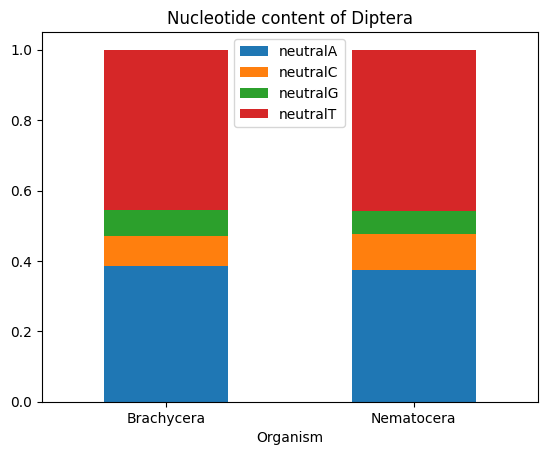

In [46]:
atgc_table = pd.concat([get_codontable(nematocera_codontable, 'Nematocera'), get_codontable(brachycera_codontable, 'Brachycera')])

pivoted = pd.pivot_table(atgc_table, columns=atgc_table.index, index=['Organism'])
pivoted = pivoted.drop(columns=['count'])
pivoted.columns = pivoted.columns.droplevel()

pivoted.plot(kind='bar', stacked=True)
plt.legend(loc='upper center')
plt.xticks(rotation = 0)
plt.title('Nucleotide content of Diptera')

In [47]:
nematocera_mutspec12 = []
for sp in nematocera_meta['Species']:
    nematocera_mutspec12.append(mutspec12.loc[mutspec12['Species'] == sp])
nematocera_mutspec12 = pd.concat(nematocera_mutspec12)

brachycera_mutspec12 = []
for sp in brachycera_meta['Species']:
    brachycera_mutspec12.append(mutspec12.loc[mutspec12['Species'] == sp])
brachycera_mutspec12 = pd.concat(brachycera_mutspec12)

In [48]:
nematocera_TC = nematocera_mutspec12[nematocera_mutspec12['Mut'] == 'T>C']
brachycera_TC = brachycera_mutspec12[brachycera_mutspec12['Mut'] == 'T>C']
nematocera_AG = nematocera_mutspec12[nematocera_mutspec12['Mut'] == 'A>G']
brachycera_AG = brachycera_mutspec12[brachycera_mutspec12['Mut'] == 'A>G']

In [48]:
mannwhitneyu(nematocera_AG['MutSpec'], brachycera_AG['MutSpec'])

MannwhitneyuResult(statistic=169412.0, pvalue=0.0008020396184799412)

In [49]:
mannwhitneyu(nematocera_TC['MutSpec'], brachycera_TC['MutSpec'])

MannwhitneyuResult(statistic=225771.0, pvalue=3.422917641547055e-08)

In [51]:
#cosine similarity
x = np.array([nematocera_AG['MutSpec'].to_list()]).T
y = np.array([brachycera_AG['MutSpec'].to_list()]).T
cdist(x, y, metric='cosine')

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

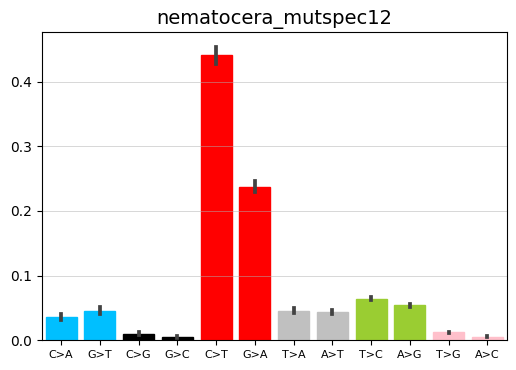

<AxesSubplot:title={'center':'nematocera_mutspec12'}>

In [50]:
draw.plot_mutspec12(nematocera_mutspec12, title='nematocera_mutspec12')

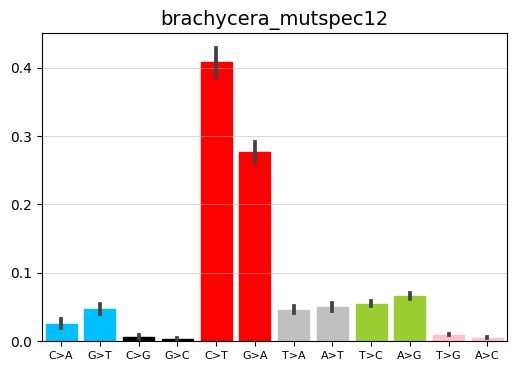

<AxesSubplot:title={'center':'brachycera_mutspec12'}>

In [51]:
draw.plot_mutspec12(brachycera_mutspec12, title='brachycera_mutspec12')

# Syrphidae stuff (family in Diptera) 

In [52]:
PATH_TO_CODONTABLE = f'/home/gabs/Documents/lab/TermitesAndCockroaches/mtdna-mutspec-insecta/data/DescriptiveStat/codontable_midori_Diptera.csv'
metadata = pd.read_csv(PATH_TO_METADATA, sep='\t', index_col=0)
syrphidae_meta = metadata.loc[metadata['Family'] == 'Syrphidae_34680']

for sp in strand_check['species']:
    syrphidae_meta = syrphidae_meta.drop(syrphidae_meta.iloc[syrphidae_meta.index == sp].index)

predator_syrph = []
predator_syrph.append(syrphidae_meta.loc[syrphidae_meta['Genus'] == 'Syrphus_224255'])
predator_syrph.append(syrphidae_meta.loc[syrphidae_meta['Genus'] == 'Scaeva_219538'])
predator_syrph.append(syrphidae_meta.loc[syrphidae_meta['Genus'] == 'Sphaerophoria_226179'])
predator_syrph.append(syrphidae_meta.loc[syrphidae_meta['Genus'] == 'Melanostoma_92597'])
predator_syrph.append(syrphidae_meta.loc[syrphidae_meta['Genus'] == 'Platycheirus_192444'])
predator_syrph.append(syrphidae_meta.loc[syrphidae_meta['Genus'] == 'Paragus_115308'])
predator_syrph.append(syrphidae_meta.loc[syrphidae_meta['Genus'] == 'Pipiza_221788'])
predator_syrph = pd.concat(predator_syrph)
predator_syrph.reset_index(inplace=True)

detritophagus_syrph = []
detritophagus_syrph.append(syrphidae_meta.loc[syrphidae_meta['Genus'] == 'Eristalis_198633'])
detritophagus_syrph.append(syrphidae_meta.loc[syrphidae_meta['Genus'] == 'Myathropa_2714348'])
detritophagus_syrph.append(syrphidae_meta.loc[syrphidae_meta['Genus'] == 'Helophilus_226173'])
detritophagus_syrph.append(syrphidae_meta.loc[syrphidae_meta['Genus'] == 'Chrysogaster_224248'])
detritophagus_syrph.append(syrphidae_meta.loc[syrphidae_meta['Genus'] == 'Sphegina_226166'])
detritophagus_syrph.append(syrphidae_meta.loc[syrphidae_meta['Genus'] == 'Neoascia_224222'])
detritophagus_syrph = pd.concat(detritophagus_syrph)
detritophagus_syrph.reset_index(inplace=True)

phytophagus_syrph = []
phytophagus_syrph.append(syrphidae_meta.loc[syrphidae_meta['Genus'] == 'Cheilosia_173981'])
phytophagus_syrph.append(syrphidae_meta.loc[syrphidae_meta['Genus'] == 'Eumerus_224220'])
phytophagus_syrph.append(syrphidae_meta.loc[syrphidae_meta['Genus'] == 'Merodon_224226'])
phytophagus_syrph = pd.concat(phytophagus_syrph)
phytophagus_syrph.reset_index(inplace=True)

xylobiont_syrph = []
xylobiont_syrph.append(syrphidae_meta.loc[syrphidae_meta['Genus'] == 'Mallota_535942'])
xylobiont_syrph.append(syrphidae_meta.loc[syrphidae_meta['Genus'] == 'Blera_226146'])
xylobiont_syrph.append(syrphidae_meta.loc[syrphidae_meta['Genus'] == 'Criorhina_224238'])
xylobiont_syrph.append(syrphidae_meta.loc[syrphidae_meta['Genus'] == 'Xylota_224240'])
xylobiont_syrph.append(syrphidae_meta.loc[syrphidae_meta['Genus'] == 'Spilomyia_226162'])
xylobiont_syrph.append(syrphidae_meta.loc[syrphidae_meta['Genus'] == 'Temnostoma_226164'])
xylobiont_syrph.append(syrphidae_meta.loc[syrphidae_meta['Genus'] == 'Brachyopa_1637464'])
xylobiont_syrph = pd.concat(xylobiont_syrph)
xylobiont_syrph.reset_index(inplace=True)

'''
#NONE OF THESE ARE PRESENT IN msMetaData
inquilin_syrph =[]
inquilin_syrph.append(syrphidae_meta.loc[syrphidae_meta['Genus'] == 'Volucella_226148'])
inquilin_syrph.append(syrphidae_meta.loc[syrphidae_meta['Genus'] == 'Microdon_115291'])
inquilin_syrph = pd.concat(inquilin_syrph)
inquilin_syrph.reset_index(inplace=True)
'''

coprobiont_syrph = []
coprobiont_syrph.append(syrphidae_meta.loc[syrphidae_meta['Genus'] == 'Syritta_34681'])
coprobiont_syrph.append(syrphidae_meta.loc[syrphidae_meta['Genus'] == 'Rhingia_192449'])
coprobiont_syrph = pd.concat(coprobiont_syrph)
coprobiont_syrph.reset_index(inplace=True)

In [53]:
diptera_codontable = pd.read_csv(PATH_TO_CODONTABLE, index_col=0)
diptera_codontable['Species_name'] = list(map(lambda sp: f'{sp.split("_")[0]}_{sp.split("_")[1]}', diptera_codontable['Species_name']))

predator_syrph_codontable = []
for sp in predator_syrph['Species']:
    predator_syrph_codontable.append(diptera_codontable.loc[diptera_codontable['Species_name'] == sp])
predator_syrph_codontable = pd.concat(predator_syrph_codontable)

detritophagus_syrph_codontable = []
for sp in detritophagus_syrph['Species']:
    detritophagus_syrph_codontable.append(diptera_codontable.loc[diptera_codontable['Species_name'] == sp])
detritophagus_syrph_codontable = pd.concat(detritophagus_syrph_codontable)

"""
#NONE IN CODONTABLE
phytophagus_syrph_codontable = []
for sp in phytophagus_syrph['Species']:
    phytophagus_syrph_codontable.append(diptera_codontable.loc[diptera_codontable['Species_name'] == sp])
phytophagus_syrph_codontable = pd.concat(phytophagus_syrph_codontable)
"""

"""
#NONE IN CODONTABLE
xylobiont_syrph_codontable = []
for sp in xylobiont_syrph['Species']:
    xylobiont_syrph_codontable.append(diptera_codontable.loc[diptera_codontable['Species_name'] == sp])
xylobiont_syrph_codontable = pd.concat(xylobiont_syrph_codontable)
"""

coprobiont_syrph_codontable = []
for sp in coprobiont_syrph['Species']:
    coprobiont_syrph_codontable.append(diptera_codontable.loc[diptera_codontable['Species_name'] == sp])
coprobiont_syrph_codontable = pd.concat(coprobiont_syrph_codontable)

Text(0.5, 1.0, 'Nucleotide content of Syrphidae')

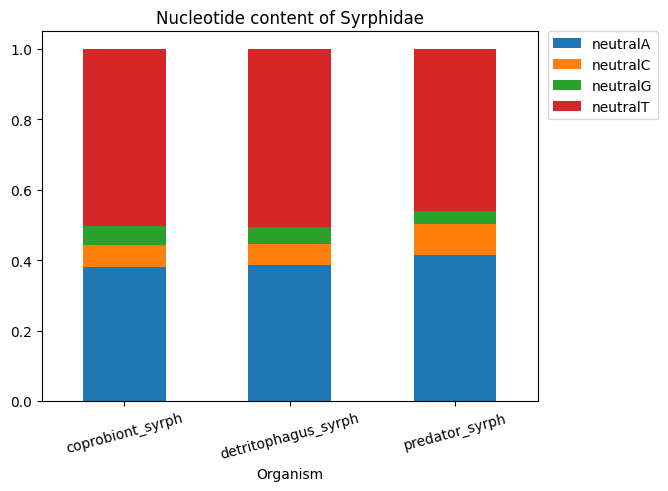

In [54]:
atgc_table = pd.concat([get_codontable(predator_syrph_codontable, 'predator_syrph'), get_codontable(detritophagus_syrph_codontable, 'detritophagus_syrph'), 
                        get_codontable(coprobiont_syrph_codontable, 'coprobiont_syrph')])

pivoted = pd.pivot_table(atgc_table, columns=atgc_table.index, index=['Organism'])
pivoted = pivoted.drop(columns=['count'])
pivoted.columns = pivoted.columns.droplevel()

pivoted.plot(kind='bar', stacked=True)
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.xticks(rotation = 15)
plt.title('Nucleotide content of Syrphidae')

In [55]:
predator_syrph_mutspec12 = []
for sp in predator_syrph['Species']:
    predator_syrph_mutspec12.append(mutspec12.loc[mutspec12['Species'] == sp])
predator_syrph_mutspec12 = pd.concat(predator_syrph_mutspec12)

detritophagus_syrph_mutspec12 = []
for sp in detritophagus_syrph['Species']:
    detritophagus_syrph_mutspec12.append(mutspec12.loc[mutspec12['Species'] == sp])
detritophagus_syrph_mutspec12 = pd.concat(detritophagus_syrph_mutspec12)

phytophagus_syrph_mutspec12 = []
for sp in phytophagus_syrph['Species']:
    phytophagus_syrph_mutspec12.append(mutspec12.loc[mutspec12['Species'] == sp])
phytophagus_syrph_mutspec12 = pd.concat(phytophagus_syrph_mutspec12)

xylobiont_syrph_mutspec12 = []
for sp in xylobiont_syrph['Species']:
    xylobiont_syrph_mutspec12.append(mutspec12.loc[mutspec12['Species'] == sp])
xylobiont_syrph_mutspec12 = pd.concat(xylobiont_syrph_mutspec12)

coprobiont_syrph_mutspec12 = []
for sp in coprobiont_syrph['Species']:
    coprobiont_syrph_mutspec12.append(mutspec12.loc[mutspec12['Species'] == sp])
coprobiont_syrph_mutspec12 = pd.concat(coprobiont_syrph_mutspec12)

In [56]:
predator_syrph_AG = predator_syrph_mutspec12[predator_syrph_mutspec12['Mut'] == 'A>G']
detritophagus_syrph_AG = detritophagus_syrph_mutspec12[detritophagus_syrph_mutspec12['Mut'] == 'A>G']
phytophagus_syrph_AG = phytophagus_syrph_mutspec12[phytophagus_syrph_mutspec12['Mut'] == 'A>G']
xylobiont_syrph_AG = xylobiont_syrph_mutspec12[xylobiont_syrph_mutspec12['Mut'] == 'A>G']
coprobiont_syrph_AG = coprobiont_syrph_mutspec12[coprobiont_syrph_mutspec12['Mut'] == 'A>G']

In [57]:
f_oneway(predator_syrph_AG['MutSpec'], detritophagus_syrph_AG['MutSpec'], phytophagus_syrph_AG['MutSpec'], xylobiont_syrph_AG['MutSpec'], coprobiont_syrph_AG['MutSpec'])

F_onewayResult(statistic=0.6530972109937212, pvalue=0.6287018148208595)

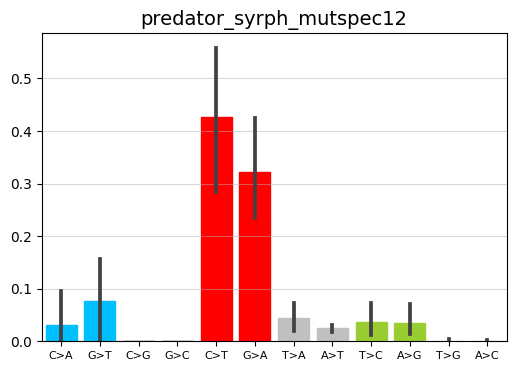

<AxesSubplot:title={'center':'predator_syrph_mutspec12'}>

In [58]:

draw.plot_mutspec12(predator_syrph_mutspec12, title='predator_syrph_mutspec12')


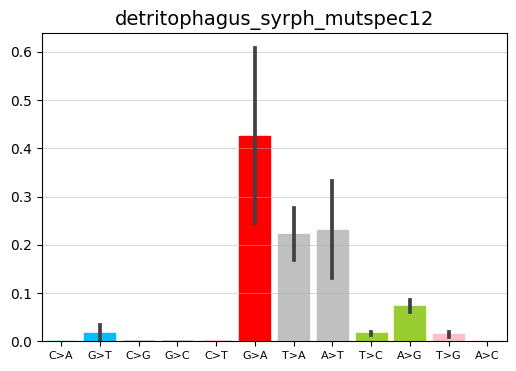

<AxesSubplot:title={'center':'detritophagus_syrph_mutspec12'}>

In [59]:
draw.plot_mutspec12(detritophagus_syrph_mutspec12, title='detritophagus_syrph_mutspec12')

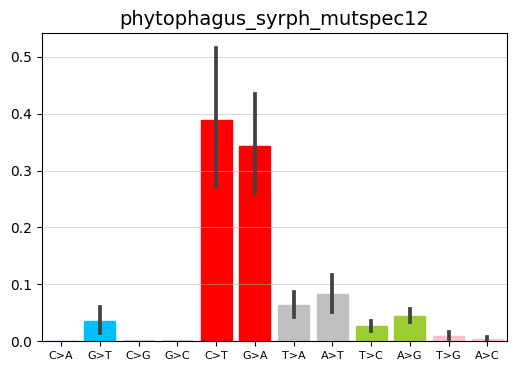

<AxesSubplot:title={'center':'phytophagus_syrph_mutspec12'}>

In [60]:
draw.plot_mutspec12(phytophagus_syrph_mutspec12, title='phytophagus_syrph_mutspec12')

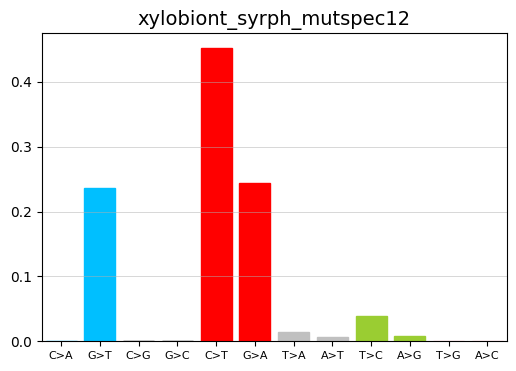

<AxesSubplot:title={'center':'xylobiont_syrph_mutspec12'}>

In [61]:
draw.plot_mutspec12(xylobiont_syrph_mutspec12, title='xylobiont_syrph_mutspec12')

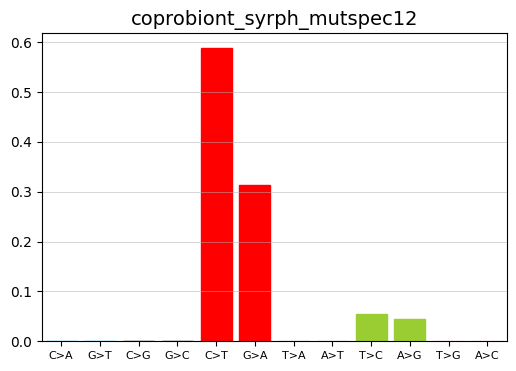

<AxesSubplot:title={'center':'coprobiont_syrph_mutspec12'}>

In [62]:
draw.plot_mutspec12(coprobiont_syrph_mutspec12, title='coprobiont_syrph_mutspec12')

# Lepidoptera stuff


In [52]:
metadata = pd.read_csv(PATH_TO_METADATA, sep='\t', index_col=0)
lepidoptera_meta = metadata.loc[metadata['Order'] == 'Lepidoptera_7088']

In [53]:
# remove species with wrong gene position
for sp in strand_check['species']:
    lepidoptera_meta = lepidoptera_meta.drop(lepidoptera_meta.iloc[lepidoptera_meta.index == sp].index)

In [54]:
lepidoptera_meta

,Class,Order,Family,Genus,Nodes_in_tree
Species,,,,,
Argyresthia_goedartella,Insecta_50557,Lepidoptera_7088,Argyresthiidae_572717,Argyresthia_572706,26.0
Copaxa_andescens,Insecta_50557,Lepidoptera_7088,Saturniidae_7117,Copaxa_180265,24.0
Rhopobota_naevana,Insecta_50557,Lepidoptera_7088,Tortricidae_7139,Rhopobota_572891,242.0
Perimede_falcata,Insecta_50557,Lepidoptera_7088,Cosmopterigidae_173647,Perimede_691670,10.0
Asota_eusemioides,Insecta_50557,Lepidoptera_7088,Erebidae_695564,Asota_95192,21.0
...,...,...,...,...,...
Arsenura_drucei,Insecta_50557,Lepidoptera_7088,Saturniidae_7117,Arsenura_315971,11.0
Biston_thibetaria,Insecta_50557,Lepidoptera_7088,Geometridae_82593,Biston_82594,12.0
Xestia_finatimis,Insecta_50557,Lepidoptera_7088,Noctuidae_7100,Xestia_320016,14.0


In [55]:
day_fams = ['Papilionidae_7143', 'Pieridae_7114', 'Lycaenidae_27544', 'Riodinidae_124343', 'Nymphalidae_33415', 'Hesperiidae_40093']
day_meta = [] 
for fam in day_fams:
    day_meta.append(lepidoptera_meta.loc[lepidoptera_meta['Family'] == fam])
day_meta = pd.concat(day_meta)
day_meta.reset_index(inplace=True)

night_fams = ['Noctuidae_7100', 'Erebidae_695564', 'Geometridae_82593', ]
night_meta = []
for fam in night_fams:
    night_meta.append(lepidoptera_meta.loc[lepidoptera_meta['Family'] == fam])
night_meta = pd.concat(night_meta)
night_meta.reset_index(inplace=True)

In [56]:
day_mutspec12 = []
for sp in day_meta['Species']:
    day_mutspec12.append(mutspec12.loc[mutspec12['Species'] == sp])
day_mutspec12 = pd.concat(day_mutspec12)

night_mutspec12 = []
for sp in night_meta['Species']:
    night_mutspec12.append(mutspec12.loc[mutspec12['Species'] == sp])
night_mutspec12 = pd.concat(night_mutspec12)

In [57]:
#cosine similarity
day_AG = day_mutspec12[day_mutspec12['Mut'] == 'A>G']
night_AG = night_mutspec12[night_mutspec12['Mut'] == 'A>G']

x = np.array([day_AG['MutSpec'].to_list()]).T
y = np.array([night_AG['MutSpec'].to_list()]).T
cdist(x, y, metric='cosine')

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

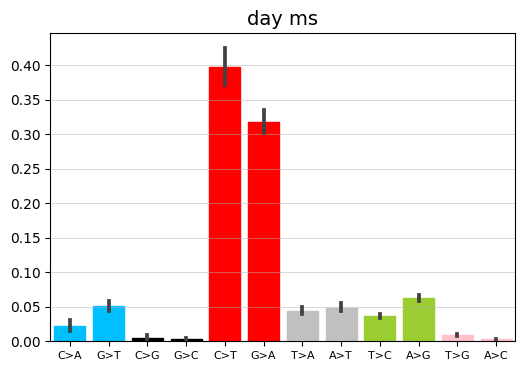

<AxesSubplot:title={'center':'day ms'}>

In [68]:
draw.plot_mutspec12(day_mutspec12, title='day ms')

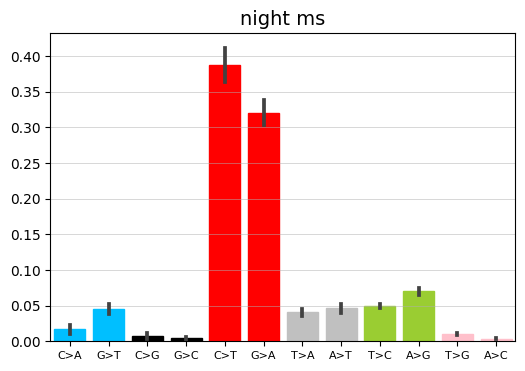

<AxesSubplot:title={'center':'night ms'}>

In [69]:
draw.plot_mutspec12(night_mutspec12, title='night ms')

# Hymenoptera stuff

### Suitable family search

In [ ]:
metadata = pd.read_csv(PATH_TO_METADATA, sep='\t', index_col=0)
hymenoptera_meta = metadata.loc[metadata['Order'] == 'Hymenoptera_7399']

In [7]:
# remove species with wrong gene position
for sp in strand_check['species']:
    hymenoptera_meta = hymenoptera_meta.drop(hymenoptera_meta.iloc[hymenoptera_meta.index == sp].index)

findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.


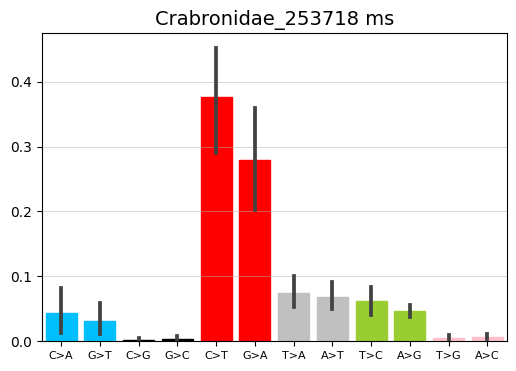

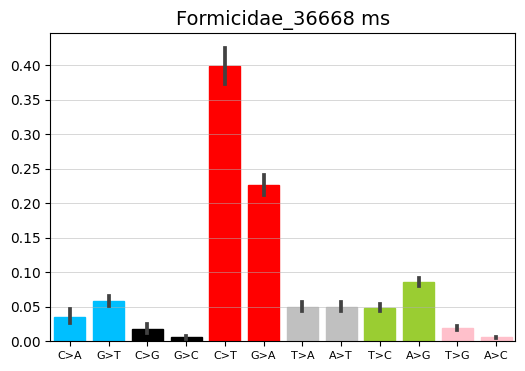

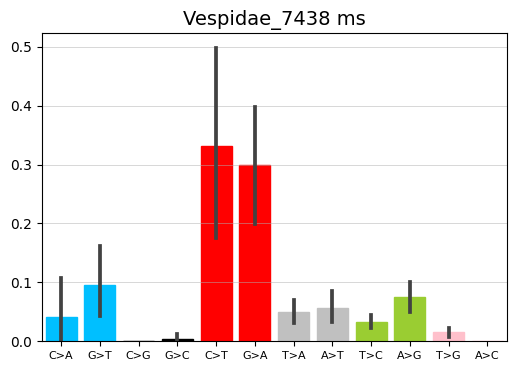

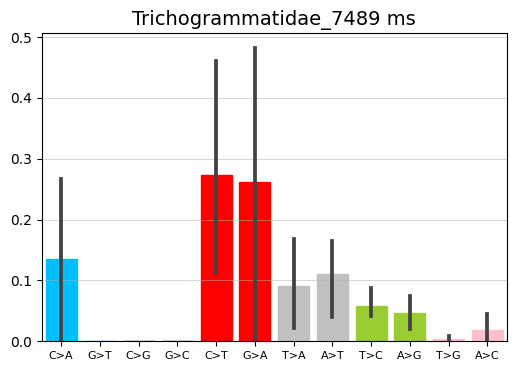

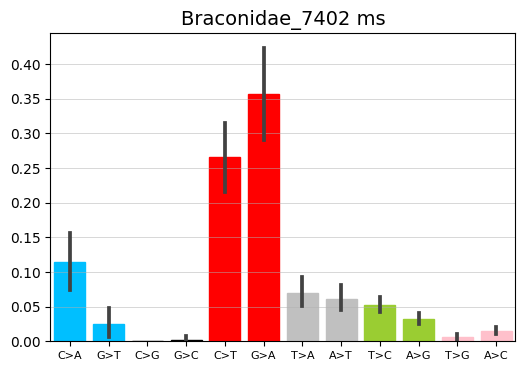

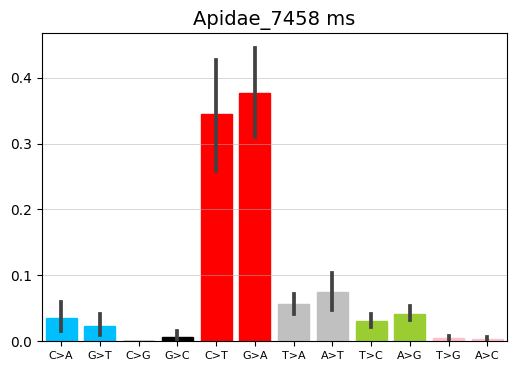

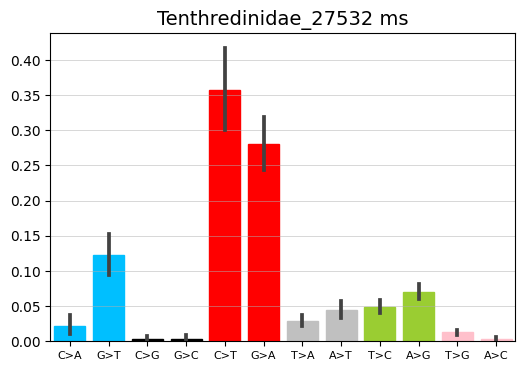

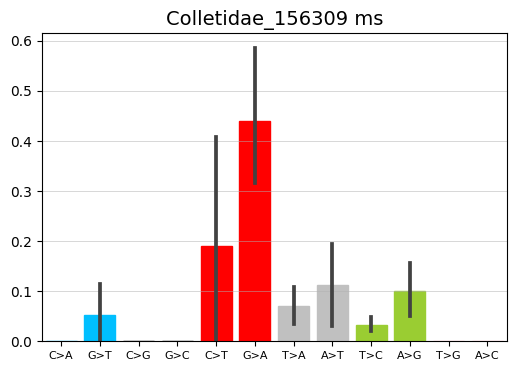

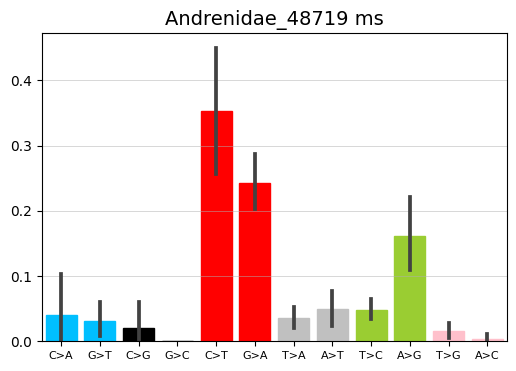

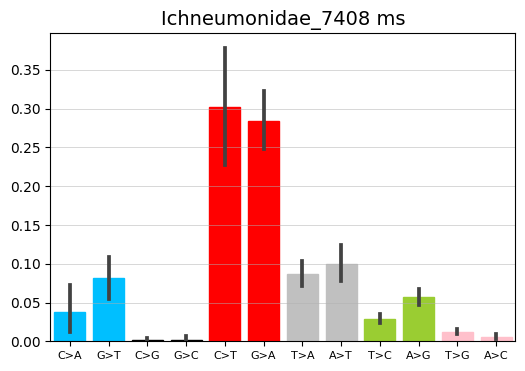

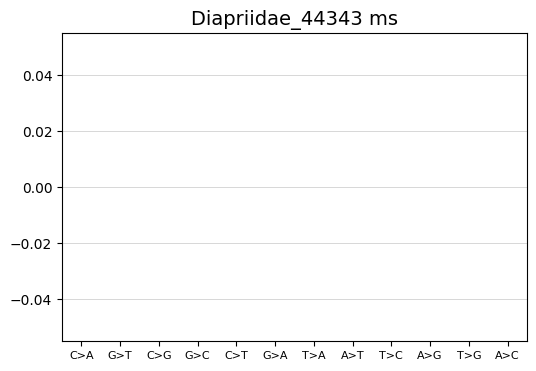

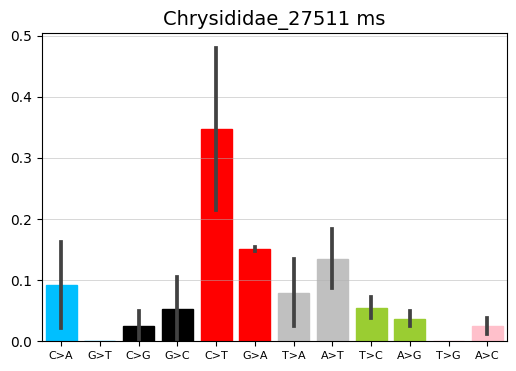

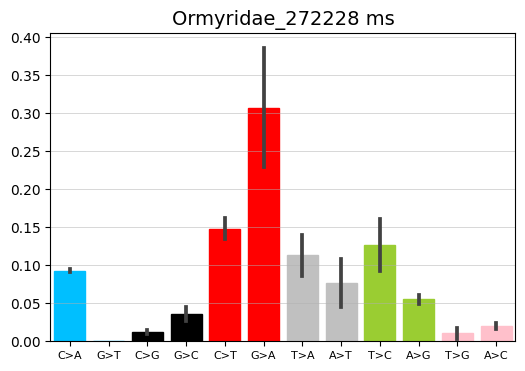

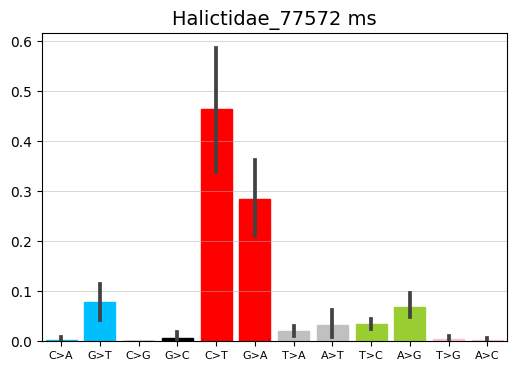

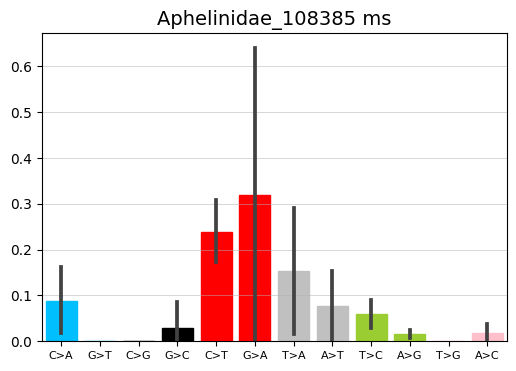

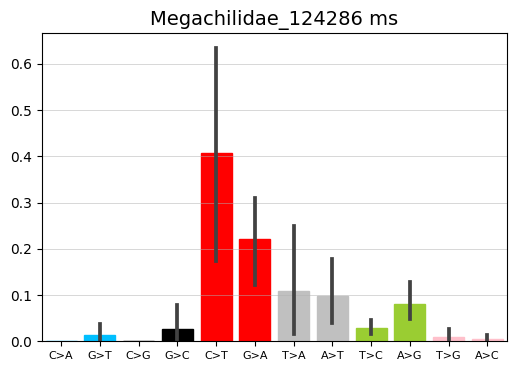

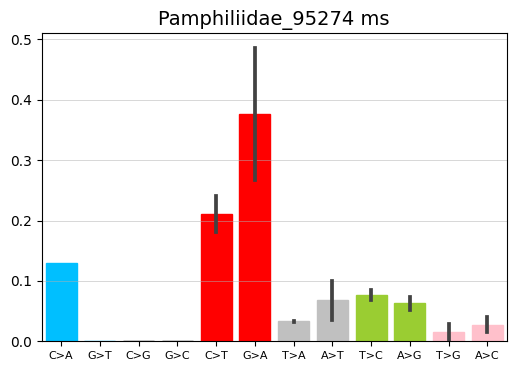

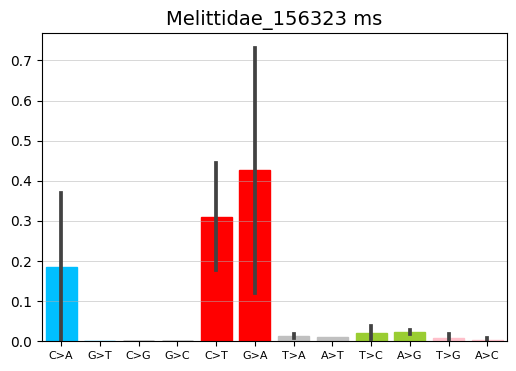

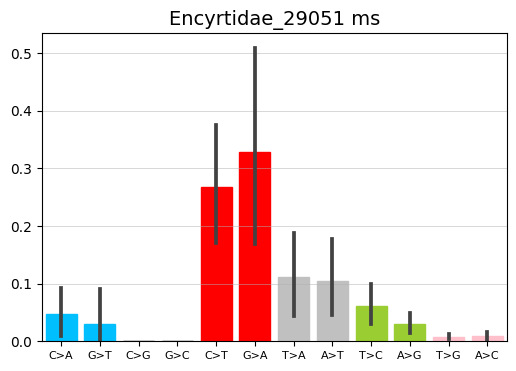

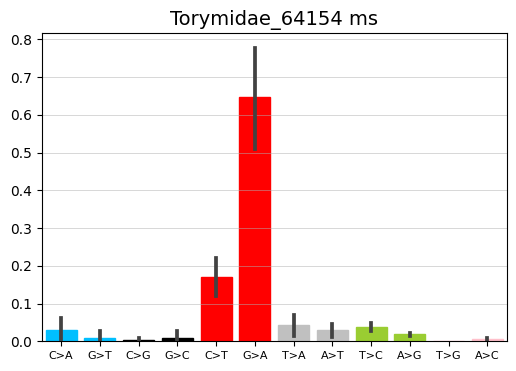

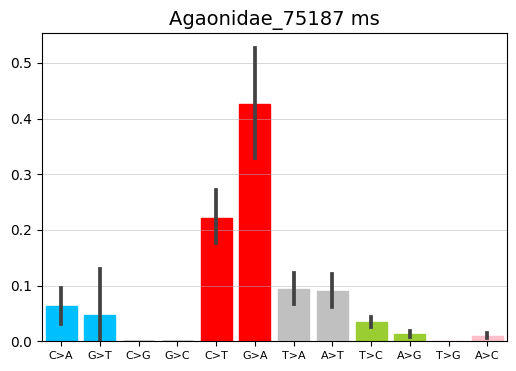

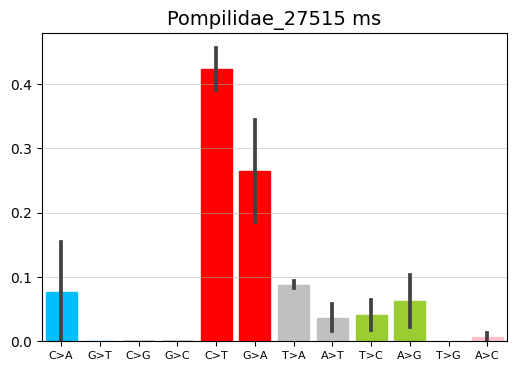

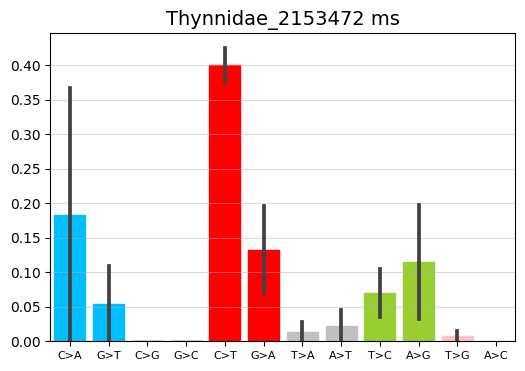

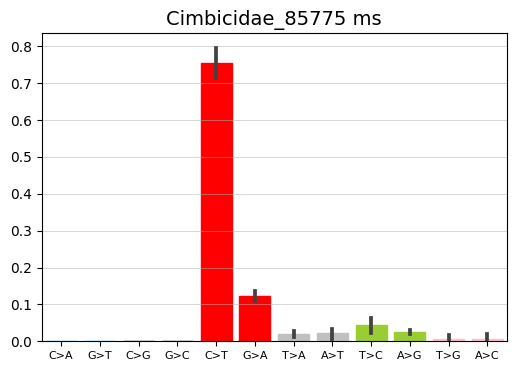

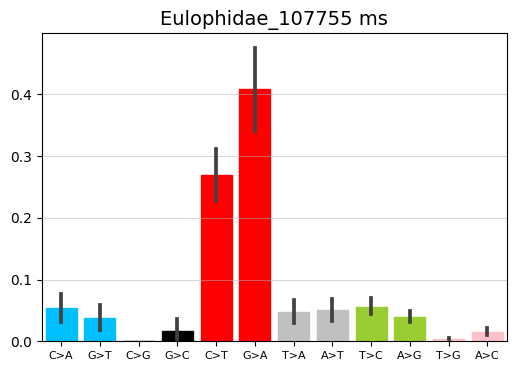

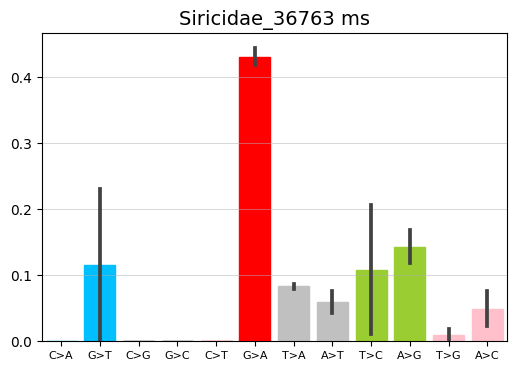

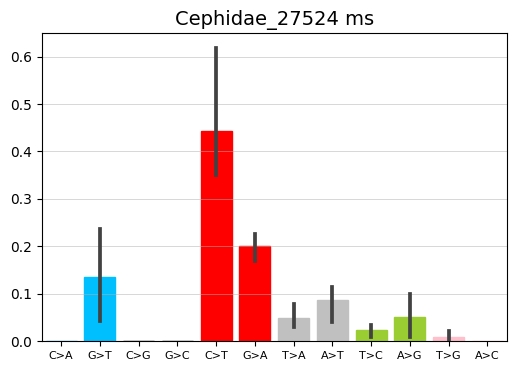

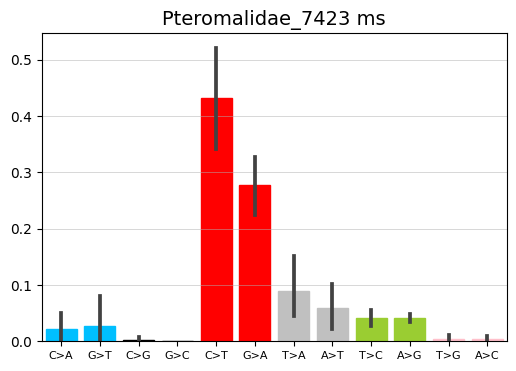

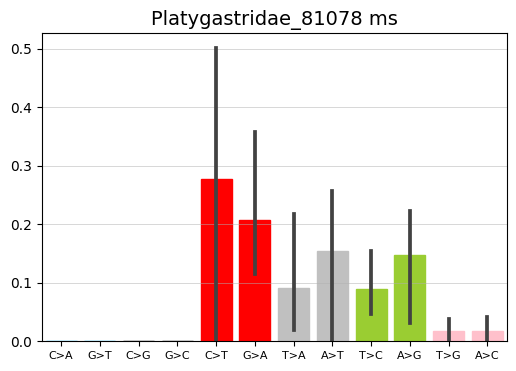

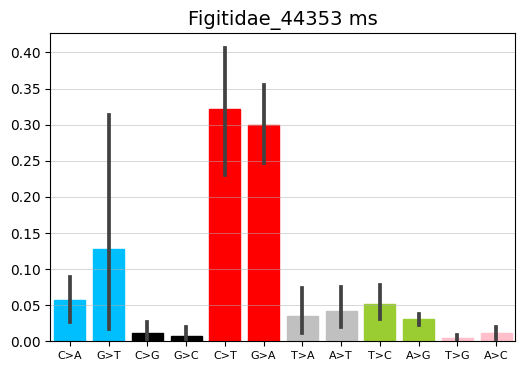

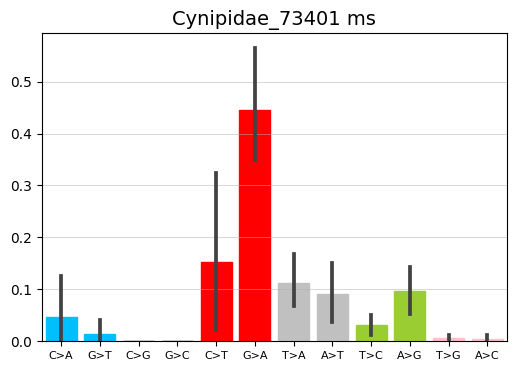

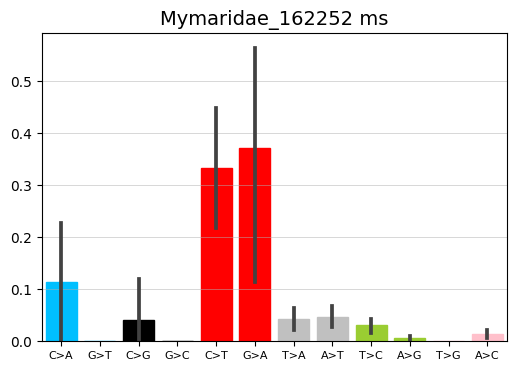

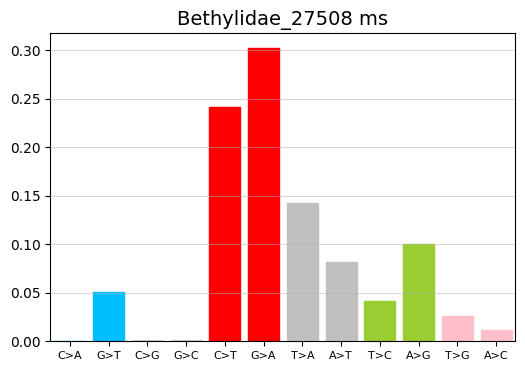

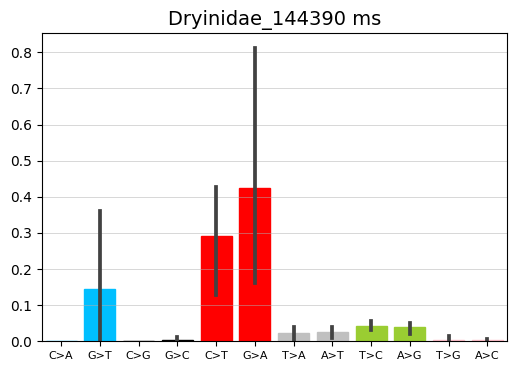

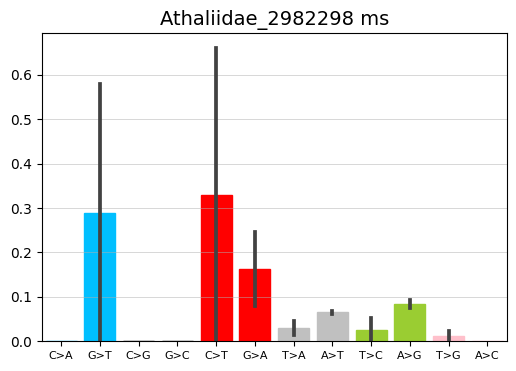

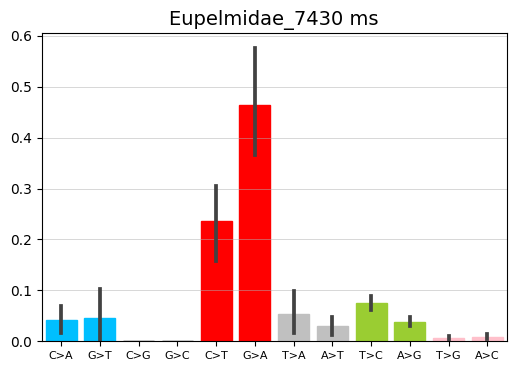

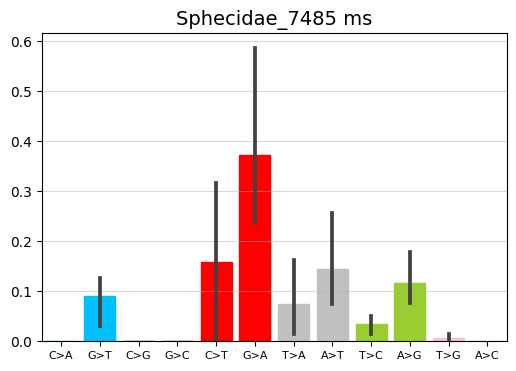

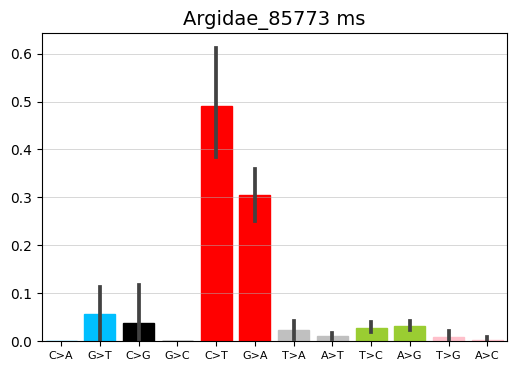

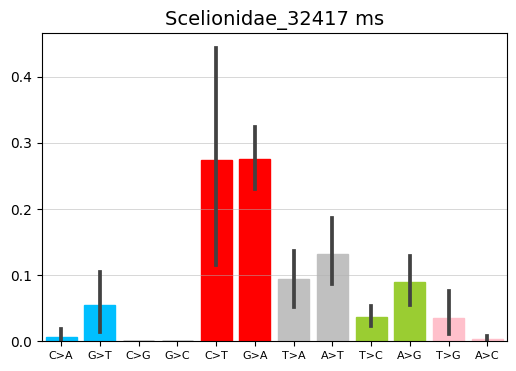

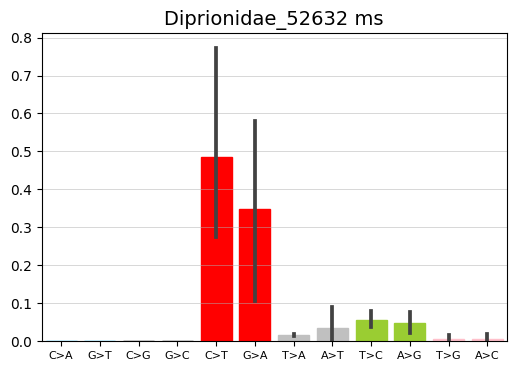

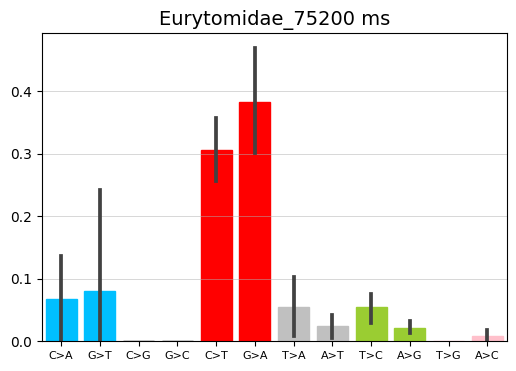

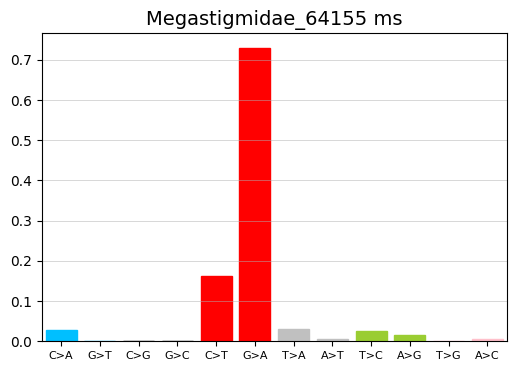

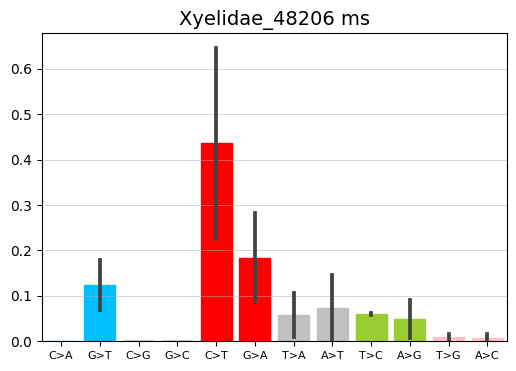

In [60]:
fams = hymenoptera_meta['Family'].unique()
fam_meanAG = {}
for fam in fams:
    fam_ms12 = []
    fam_meta = hymenoptera_meta[hymenoptera_meta['Family'] == fam]
    for sp in fam_meta.index:
        fam_ms12.append(mutspec12.loc[mutspec12['Species'] == sp])
    fam_ms12 = pd.concat(fam_ms12)
    fam_meanAG[fam] = fam_ms12.loc[fam_ms12['Mut'] == 'A>G', 'MutSpec'].mean()
    draw.plot_mutspec12(fam_ms12, title=f'{fam} ms')


In [73]:
fam_meanAG = pd.DataFrame([fam_meanAG]).T
fam_meanAG = fam_meanAG.rename(columns={0:'mutspec'})

<AxesSubplot:ylabel='Count'>

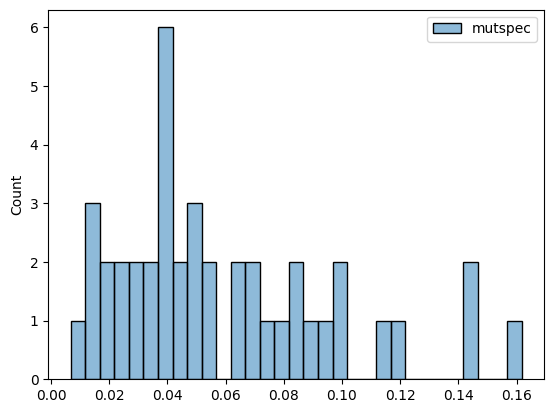

In [74]:
sns.histplot(fam_meanAG, binwidth=0.005)

In [75]:
fam_meanAG.nlargest(n=5, columns='mutspec')

,mutspec
Andrenidae_48719,0.161398
Platygastridae_81078,0.146676
Siricidae_36763,0.143412
Sphecidae_7485,0.116814
Thynnidae_2153472,0.114888


In [76]:
fam_meanAG.nsmallest(n=5, columns='mutspec')

,mutspec
Mymaridae_162252,0.006742
Agaonidae_75187,0.013654
Megastigmidae_64155,0.015062
Aphelinidae_108385,0.016464
Torymidae_64154,0.017996


In [77]:
fam_meanAG.sort_values(by=['mutspec'], ascending=False)

,mutspec
Andrenidae_48719,0.161398
Platygastridae_81078,0.146676
Siricidae_36763,0.143412
Sphecidae_7485,0.116814
Thynnidae_2153472,0.114888
Colletidae_156309,0.101151
Bethylidae_27508,0.100578
Cynipidae_73401,0.096653
Scelionidae_32417,0.089596
Formicidae_36668,0.085831


### Apidae vs Megachilidae comaprison

In [30]:
apidae_ms = [] #social (NOT ALL OF THEM, MOSTLY HONEYBEES AND BUMBLEBEES)
apidae_meta = hymenoptera_meta[hymenoptera_meta['Family'] == 'Apidae_7458']
for sp in apidae_meta.index:
        apidae_ms.append(mutspec12.loc[mutspec12['Species'] == sp])
apidae_ms = pd.concat(apidae_ms)

megachil_ms = [] #not social
megachil_meta = hymenoptera_meta[hymenoptera_meta['Family'] == 'Megachilidae_124286']
for sp in megachil_meta.index:
        megachil_ms.append(mutspec12.loc[mutspec12['Species'] == sp])
megachil_ms = pd.concat(megachil_ms)


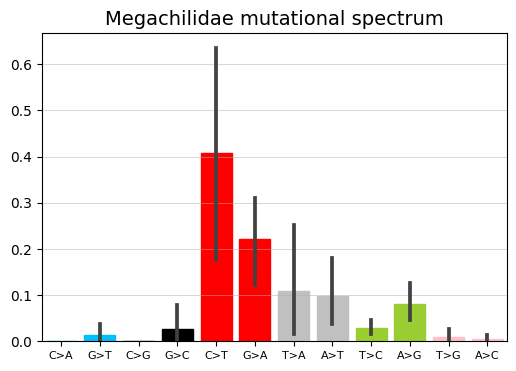

<AxesSubplot:title={'center':'Megachilidae mutational spectrum'}>

In [62]:
draw.plot_mutspec12(megachil_ms, title="Megachilidae mutational spectrum")

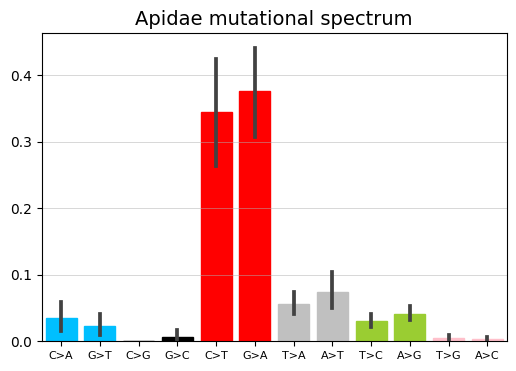

<AxesSubplot:title={'center':'Apidae mutational spectrum'}>

In [63]:
draw.plot_mutspec12(apidae_ms, title="Apidae mutational spectrum")

In [91]:
mannwhitneyu(apidae_ms.loc[apidae_ms['Mut'] == 'A>G', 'MutSpec'], megachil_ms.loc[megachil_ms['Mut'] == 'A>G', 'MutSpec'])

MannwhitneyuResult(statistic=79.0, pvalue=0.017801944579209607)

In [65]:
#cosine similarity
apidae_AG = apidae_ms[apidae_ms['Mut'] == 'A>G']
megachil_AG = megachil_ms[megachil_ms['Mut'] == 'A>G']

x = np.array([apidae_AG['MutSpec'].to_list()]).T
y = np.array([megachil_AG['MutSpec'].to_list()]).T
cdist(x, y, metric='cosine')

array([[ 0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [nan, nan, nan, nan, nan, nan, nan],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,

### Short tongue vs long tongue

In [18]:
long_tongue_ms = []
long_tongue_meta = []
long_tongue_fams = ['Apidae_7458', 'Megachilidae_124286']
for fam in long_tongue_fams:
        long_tongue_meta.append(hymenoptera_meta[hymenoptera_meta['Family'] == fam])
long_tongue_meta = pd.concat(long_tongue_meta)

for sp in long_tongue_meta.index:
        long_tongue_ms.append(mutspec12.loc[mutspec12['Species'] == sp])
long_tongue_ms = pd.concat(long_tongue_ms)

short_tongue_ms = []
short_tongue_meta = []
short_tongue_fams = ['Andrenidae_48719', 'Halictidae_77572', 'Colletidae_156309']
for fam in short_tongue_fams:
        short_tongue_meta.append(hymenoptera_meta[hymenoptera_meta['Family'] == fam])
short_tongue_meta = pd.concat(short_tongue_meta)

for sp in short_tongue_meta.index:
        short_tongue_ms.append(mutspec12.loc[mutspec12['Species'] == sp])
short_tongue_ms = pd.concat(short_tongue_ms)


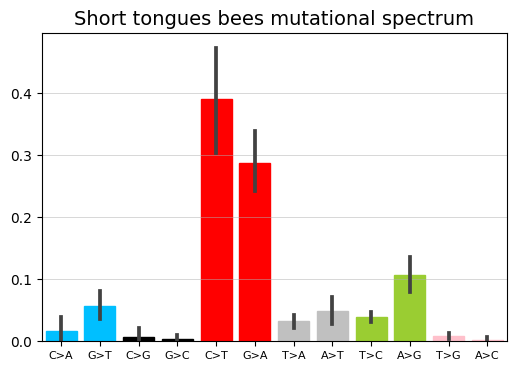

<AxesSubplot:title={'center':'Short tongues bees mutational spectrum'}>

In [19]:
draw.plot_mutspec12(short_tongue_ms, title="Short tongues bees mutational spectrum")

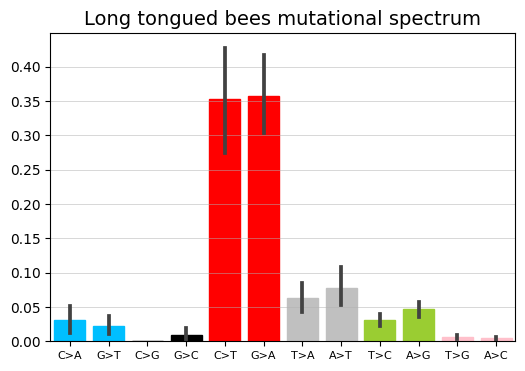

<AxesSubplot:title={'center':'Long tongued bees mutational spectrum'}>

In [20]:
draw.plot_mutspec12(long_tongue_ms, title="Long tongued bees mutational spectrum")

In [70]:
mannwhitneyu(short_tongue_ms.loc[short_tongue_ms['Mut'] == 'A>G', 'MutSpec'], long_tongue_ms.loc[long_tongue_ms['Mut'] == 'A>G', 'MutSpec'])

MannwhitneyuResult(statistic=1723.0, pvalue=6.612311973903938e-05)

In [73]:
#cosine similarity
short_tongue_AG = short_tongue_ms[short_tongue_ms['Mut'] == 'A>G']
long_tongue_AG = long_tongue_ms[long_tongue_ms['Mut'] == 'A>G']

x = np.array([short_tongue_AG['MutSpec'].to_list()]).T
y = np.array([long_tongue_AG['MutSpec'].to_list()]).T
cdist(x, y, metric='cosine')

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [21]:
PATH_TO_CODONTABLE = f'/home/gabs/Documents/lab/TermitesAndCockroaches/mtdna-mutspec-insecta/data/DescriptiveStat/codontable_midori_Hymenoptera.csv'
hymenoptera_codontable = pd.read_csv(PATH_TO_CODONTABLE, index_col=0)
hymenoptera_codontable['Species_name'] = list(map(lambda sp: f'{sp.split("_")[0]}_{sp.split("_")[1]}', hymenoptera_codontable['Species_name']))
short_tongue_meta.reset_index(inplace=True)
long_tongue_meta.reset_index(inplace=True)

short_tongue_codontable = []
for sp in short_tongue_meta['Species']:
    short_tongue_codontable.append(hymenoptera_codontable.loc[hymenoptera_codontable['Species_name'] == sp])
short_tongue_codontable = pd.concat(short_tongue_codontable)

long_tongue_codontable = []
for sp in long_tongue_meta['Species']:
    long_tongue_codontable.append(hymenoptera_codontable.loc[hymenoptera_codontable['Species_name'] == sp])
long_tongue_codontable = pd.concat(long_tongue_codontable)

Text(0.5, 1.0, 'Nucleotide content of Hymenoptera')

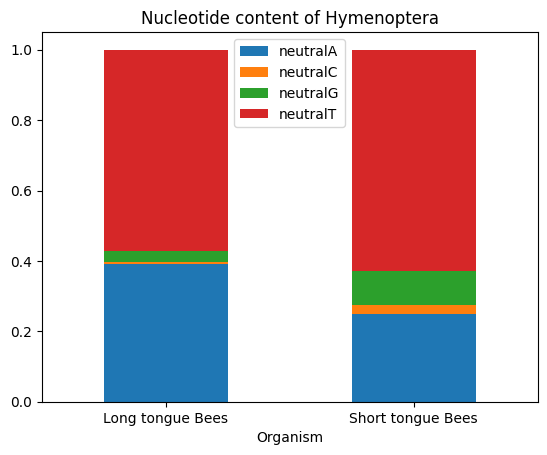

In [22]:
atgc_table = pd.concat([get_codontable(short_tongue_codontable, 'Short tongue Bees'), get_codontable(long_tongue_codontable, 'Long tongue Bees')])

pivoted = pd.pivot_table(atgc_table, columns=atgc_table.index, index=['Organism'])
pivoted = pivoted.drop(columns=['count'])
pivoted.columns = pivoted.columns.droplevel()

pivoted.plot(kind='bar', stacked=True)
plt.legend(loc='upper center')
plt.xticks(rotation = 0)
plt.title('Nucleotide content of Hymenoptera')

### Social Apidae vs Non social Apidae


In [8]:
social_genuses = ['Bombus_28641', 'Apis_7459', 'Exoneurella_78179', 'Ceratina_78173', 'Melipona_28651', 'Partamona_166432', 'Euglossa_60901', 'Tetragonula_398144']
nonsocial_genuses = ['Xylocopa_7476', 'Amegilla_261957', 'Anthophora_60896', 'Nomada_95295', 'Eulaema_28646', 'Eucera_481579', 'Epeolus_156317']

social_meta = []
for genus in social_genuses:
    social_meta.append(hymenoptera_meta[hymenoptera_meta['Genus'] == genus])
social_meta = pd.concat(social_meta)

social_ms = []
for sp in social_meta.index:
    social_ms.append(mutspec12.loc[mutspec12['Species'] == sp])
social_ms = pd.concat(social_ms)

nonsocial_meta = []
for genus in nonsocial_genuses:
    nonsocial_meta.append(hymenoptera_meta[hymenoptera_meta['Genus'] == genus])
nonsocial_meta = pd.concat(nonsocial_meta)

nonsocial_ms = []
for sp in nonsocial_meta.index:
    nonsocial_ms.append(mutspec12.loc[mutspec12['Species'] == sp])
nonsocial_ms = pd.concat(nonsocial_ms)

findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.


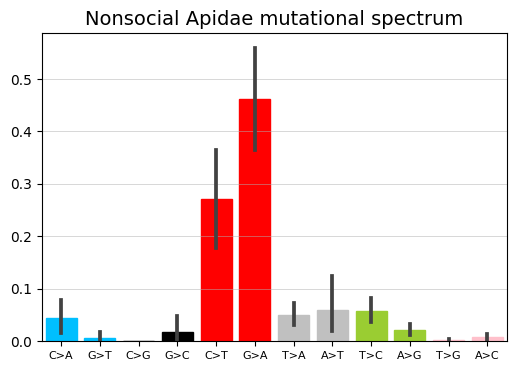

<AxesSubplot:title={'center':'Nonsocial Apidae mutational spectrum'}>

In [9]:
draw.plot_mutspec12(nonsocial_ms, title="Nonsocial Apidae mutational spectrum")

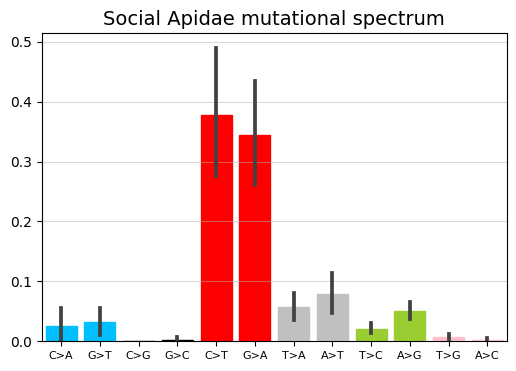

<AxesSubplot:title={'center':'Social Apidae mutational spectrum'}>

In [10]:
draw.plot_mutspec12(social_ms, title="Social Apidae mutational spectrum")

In [14]:
#cosine similarity
social_AG = social_ms[social_ms['Mut'] == 'A>G']
nonsocial_AG = nonsocial_ms[nonsocial_ms['Mut'] == 'A>G']

x = np.array([social_AG['MutSpec'].to_list()]).T
y = np.array([nonsocial_AG['MutSpec'].to_list()]).T
cdist(x, y, metric='cosine')

array([[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0., 

In [11]:
#nuc content for CO1 ONLY!
PATH_TO_CODONTABLE = f'/home/gabs/Documents/lab/TermitesAndCockroaches/mtdna-mutspec-insecta/data/DescriptiveStat/codontable_midori_Apidae_CO1.csv'
hymenoptera_codontable = pd.read_csv(PATH_TO_CODONTABLE, index_col=0)
hymenoptera_codontable['Species_name'] = list(map(lambda sp: f'{sp.split("_")[0]}_{sp.split("_")[1]}', hymenoptera_codontable['Species_name']))
social_meta.reset_index(inplace=True)
nonsocial_meta.reset_index(inplace=True)

social_codontable = []
for sp in social_meta['Species']:
    social_codontable.append(hymenoptera_codontable.loc[hymenoptera_codontable['Species_name'] == sp])
social_codontable = pd.concat(social_codontable)

nonsocial_codontable = []
for sp in nonsocial_meta['Species']:
    nonsocial_codontable.append(hymenoptera_codontable.loc[hymenoptera_codontable['Species_name'] == sp])
nonsocial_codontable = pd.concat(nonsocial_codontable)


Text(0.5, 1.0, 'Nucleotide content of Apidae')

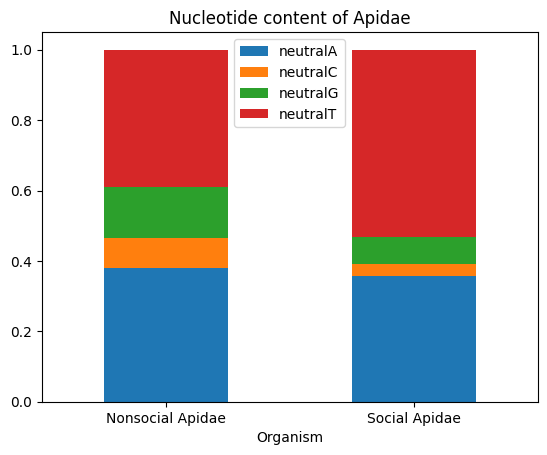

In [14]:
atgc_table = pd.concat([get_codontable(social_codontable, 'Social Apidae'), get_codontable(nonsocial_codontable, 'Nonsocial Apidae')])

pivoted = pd.pivot_table(atgc_table, columns=atgc_table.index, index=['Organism'])
pivoted = pivoted.drop(columns=['count'])
pivoted.columns = pivoted.columns.droplevel()

pivoted.plot(kind='bar', stacked=True)
plt.legend(loc='upper center')
plt.xticks(rotation = 0)
plt.title('Nucleotide content of Apidae')

# Orthoptera stuff

In [6]:
metadata = pd.read_csv(PATH_TO_METADATA, sep='\t', index_col=0)
orthoptera_meta = metadata.loc[metadata['Order'] == 'Orthoptera_6993']
orthoptera_traits = pd.read_csv('/mnt/data/Documents/lab/TermitesAndCockroaches/mtdna-mutspec-insecta/data/EcoMorphDBs/orthoptera_lifetraits.tsv', sep='\t')

In [7]:
# remove species with wrong gene position
for sp in strand_check['species']:
    orthoptera_meta = orthoptera_meta.drop(orthoptera_meta.iloc[orthoptera_meta.index == sp].index)

In [15]:
orthoptera_meta

,Class,Order,Family,Genus,Nodes_in_tree
Species,,,,,
Trimerotropis_andeana,Insecta_50557,Orthoptera_6993,Acrididae_7002,Trimerotropis_37253,23.0
Melanoplus_packardii,Insecta_50557,Orthoptera_6993,Acrididae_7002,Melanoplus_30252,22.0
Hemiandrus_pallitarsis,Insecta_50557,Orthoptera_6993,Anostostomatidae_108522,Hemiandrus_208761,45.0
Hemideina_thoracica,Insecta_50557,Orthoptera_6993,Anostostomatidae_108522,Hemideina_58603,96.0
Oecanthus_nigricornis,Insecta_50557,Orthoptera_6993,Gryllidae_6995,Oecanthus_208682,10.0
...,...,...,...,...,...
Kosciuscola_cuneatus,Insecta_50557,Orthoptera_6993,Acrididae_7002,Kosciuscola_999885,14.0
Anaxipha_exigua,Insecta_50557,Orthoptera_6993,Gryllidae_6995,Anaxipha_209174,12.0
Stenopelmatus,Insecta_50557,Orthoptera_6993,Stenopelmatidae_62771,Stenopelmatus_186126,65.0


findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.


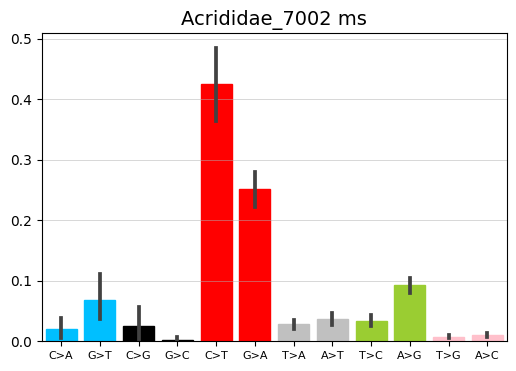

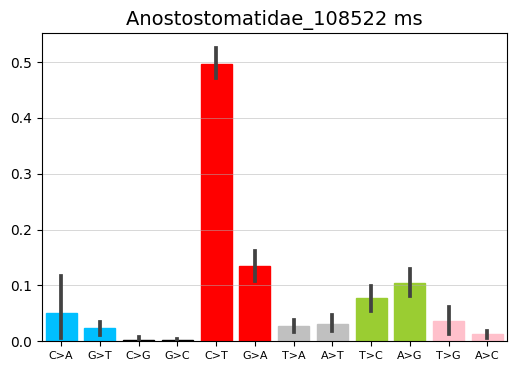

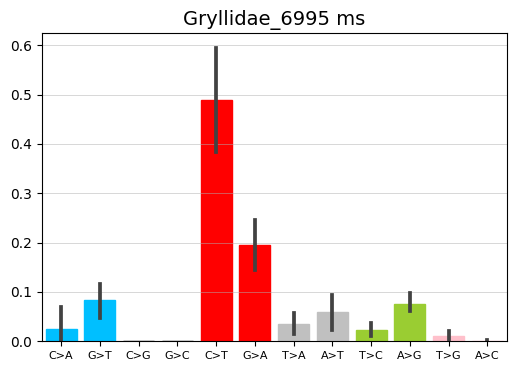

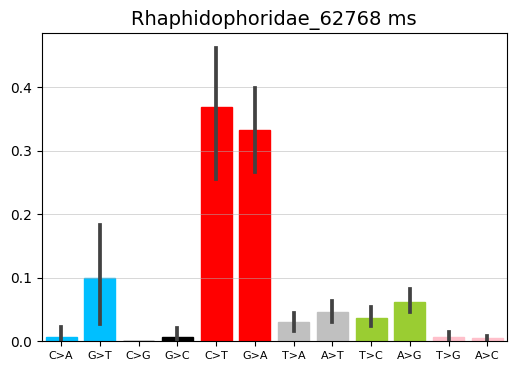

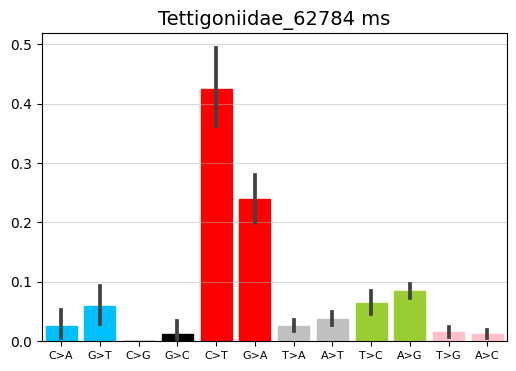

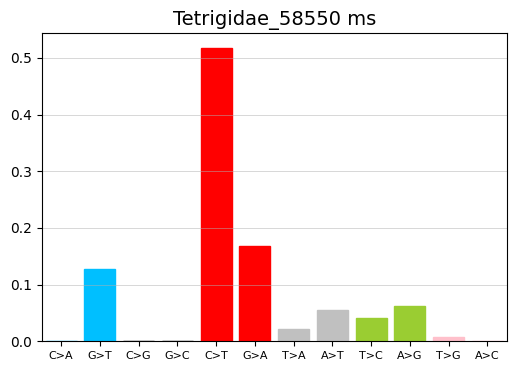

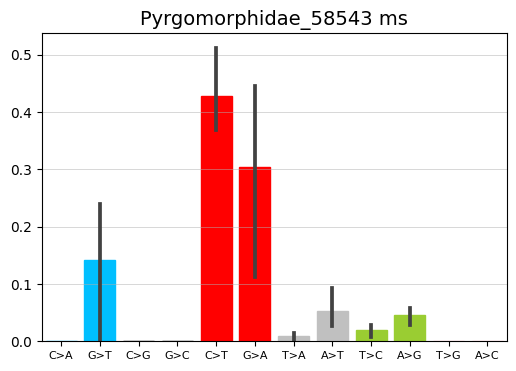

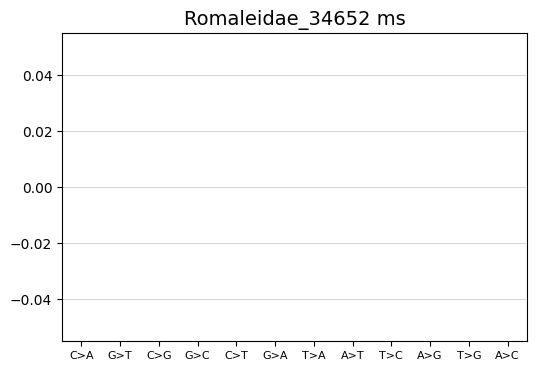

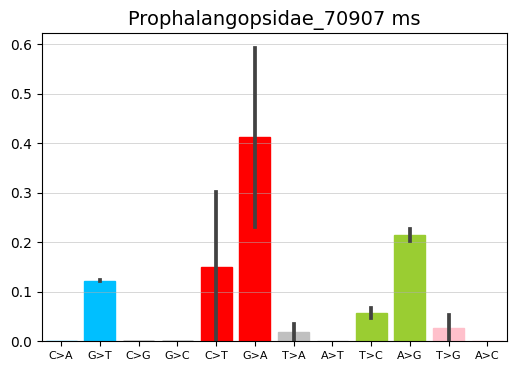

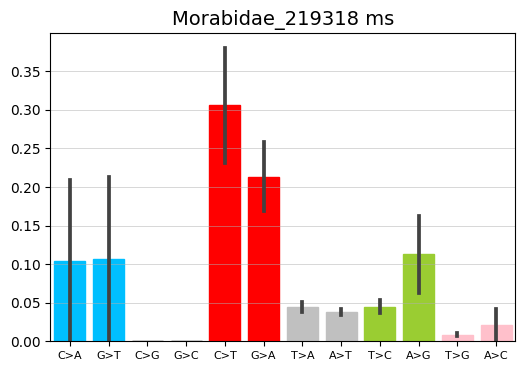

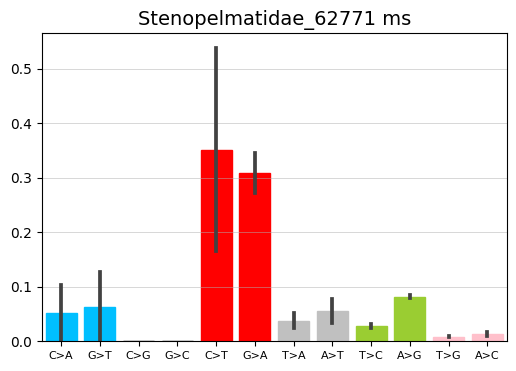

In [12]:
fams = orthoptera_meta['Family'].unique()
fam_meanAG = {}
for fam in fams:
    fam_ms12 = []
    fam_meta = orthoptera_meta[orthoptera_meta['Family'] == fam]
    for sp in fam_meta.index:
        fam_ms12.append(mutspec12.loc[mutspec12['Species'] == sp])
    fam_ms12 = pd.concat(fam_ms12)
    fam_meanAG[fam] = fam_ms12.loc[fam_ms12['Mut'] == 'A>G', 'MutSpec'].mean()
    draw.plot_mutspec12(fam_ms12, title=f'{fam} ms')


In [9]:
tmp = []
for sp in orthoptera_meta.index:
    tmp.append(orthoptera_traits.loc[orthoptera_traits['Species'] == sp])
orthoptera_traits = pd.concat(tmp)
orthoptera_traits['A>G'] = np.nan

orthoptera_meta.reset_index(inplace=True)
orthoptera_traits['Family'] = ''
for sp in orthoptera_meta['Species']:
    fam = orthoptera_meta.loc[orthoptera_meta['Species'] == sp, 'Family'].to_numpy()
    orthoptera_traits.loc[orthoptera_traits['Species'] == sp,  'Family'] = fam

In [10]:
orthoptera_mutspec = []
for sp in orthoptera_traits['Species']:
    orthoptera_mutspec.append(mutspec12.loc[mutspec12['Species'] == sp])
orthoptera_mutspec = pd.concat(orthoptera_mutspec)

orthoptera_AG = orthoptera_mutspec[orthoptera_mutspec['Mut'] == 'A>G']

In [11]:
for sp in orthoptera_AG['Species']:
    ms_val = orthoptera_AG.loc[orthoptera_AG['Species'] == sp, 'MutSpec'].to_numpy()
    orthoptera_traits.loc[orthoptera_traits['Species'] == sp, 'A>G'] = ms_val
orthoptera_traits.dropna(subset=['A>G'], inplace=True)

In [12]:
orthoptera_len = orthoptera_traits[['Species', 'Family', 'Length', 'A>G']]
orthoptera_len.dropna(inplace=True)

/tmp/ipykernel_81911/2105877297.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  orthoptera_len.dropna(inplace=True)


In [13]:
fig = px.scatter(orthoptera_len, x='A>G', y='Length', color='Family', color_discrete_sequence=px.colors.qualitative.Light24, hover_data=['Species'])
fig.update_layout(width=1440,
    height=700,
    )
fig.show()

In [14]:
rho, p = spearmanr(orthoptera_len['A>G'], orthoptera_len['Length'])
print(f'Orthoptera spearman:\nRho --- {rho}\np-value --- {p}')

Orthoptera spearman:
Rho --- -0.0756848378104858
p-value --- 0.7378119636558731


In [15]:
orthoptera_clutch_size = orthoptera_traits[['Species', 'Family', 'Clutch_S', 'A>G']]
orthoptera_clutch_size.dropna(inplace=True)

/tmp/ipykernel_81911/2986246453.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [16]:
fig = px.scatter(orthoptera_clutch_size, x='A>G', y='Clutch_S', color='Family', color_discrete_sequence=px.colors.qualitative.Light24, hover_data=['Species'])
fig.update_layout(width=1440,
    height=700,
    )
fig.show()

In [17]:
rho, p = spearmanr(orthoptera_clutch_size['A>G'], orthoptera_clutch_size['Clutch_S'])
print(f'Orthoptera spearman:\nRho --- {rho}\np-value --- {p}')

Orthoptera spearman:
Rho --- 0.24642479158111236
p-value --- 0.39572323328052506


# Hemiptera stuff

In [15]:
metadata = pd.read_csv(PATH_TO_METADATA, sep='\t', index_col=0)
hemiptera_meta = metadata.loc[metadata['Order'] == 'Hemiptera_7524']

In [16]:
hemiptera_meta['Family'].unique()

array(['Aphididae_27482', 'Adelgidae_33383', 'Corixidae_236405',
       'Miridae_30083', 'Aleyrodidae_7036', 'Rhopalidae_38106',
       'Psyllidae_30092', 'Reduviidae_27479', 'Phymatidae_237172',
       'Alydidae_41702', 'Cicadellidae_30102', 'Pentatomidae_160513',
       'Aphrophoridae_36666', 'Scutelleridae_468258', 'Pemphigidae_30187',
       'Coreidae_186376', 'Pseudococcidae_30190', 'Anthocoridae_82738',
       'Cimicidae_30078', 'Gerridae_36161', 'Saldidae_50654',
       'Clastopteridae_139606', 'Liviidae_1585420',
       'Belostomatidae_38099', 'Notonectidae_50616', 'Cicadidae_7033',
       'Aphalaridae_1566705', 'Lygaeidae_7533', 'Nabidae_57993',
       'Triozidae_38124', 'Veliidae_95677', 'Coccidae_30189',
       'Dactylopiidae_38115', 'Diaspididae_30080', 'Mindaridae_33388',
       'Tingidae_236450', 'Delphacidae_33362', 'Rhyparochromidae_238617',
       'Acanaloniidae_389990', 'Membracidae_30095', 'Cixiidae_36152',
       'Eriococcidae_240288', 'Hormaphididae_30161'], dtype=